
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU
* Next Cast is green line
* Saves Results to text file



## Parameters


In [1]:

vocab_size = 1000

comment_exp = "tok_embMpos_embMconv_emb"



## Experimental Details


In [2]:


exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.close()




## Libraries


In [3]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [4]:

import pandas as pd
import numpy as np


In [5]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [6]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [7]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [8]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [9]:

from einops import rearrange
from math import sqrt, log


In [10]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Positional Encoding example


In [11]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe


In [12]:

res = PositionalEncoding(15, 512, normalize=True)
res.shape


torch.Size([15, 512])

In [13]:

device = "cpu"


In [14]:

x_enc = torch.rand( 8, 15, 512)
print( x_enc.shape )


torch.Size([8, 15, 512])


In [15]:

pos_emb_table_rc         = nn.Embedding(15, 512)     ## [15, 512]


In [16]:

torch.arange(15, device=device)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [17]:

pos_emb = pos_emb_table_rc( torch.arange(15, device=device) ) 


In [18]:

pos_emb.shape


torch.Size([15, 512])

In [19]:

res = x_enc + pos_emb


In [20]:

res.shape


torch.Size([8, 15, 512])


## Moving Avg example


In [21]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [22]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [23]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [24]:

for_RNN_data_CIVS


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0              1  0.719500                4.242439          2161.425209   
1              2  0.710486                4.174343          2168.238915   
2              3  0.666106                4.126144          2167.779119   
3              4  0.675145                4.120736          2166.974740   
4              5  0.776831                4.120331          2166.384674   
...          ...       ...                     ...                  ...   
1378        1379  0.762500                4.204430          2169.361647   
1379        1380  0.646000                4.208539          2169.079601   
1380        1381  0.654667                4.212648          2168.797556   
1381        1382  0.591667                4.217784          2168.444999   
1382        1383  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SE_Uptake_f3  NW_Uptake_f3  \
0              0.354        0.16  ...    182.533770    148.126483   
1              0.313        0.83  ...    183.725050    148.161842   
2              0.360        0.10  ...    195.812061    147.562523   
3              0.319        0.34  ...    188.028883    147.807509   
4              0.335        0.28  ...    200.141261    149.014319   
...              ...         ...  ...           ...           ...   
1378           0.343        0.30  ...    185.900341    148.103530   
1379           0.324        0.30  ...    182.408576    148.106012   
1380           0.325        0.16  ...    181.684649    148.108493   
1381           0.335        0.26  ...    195.202191    148.111595   
1382           0.328        1.08  ...    220.149599    148.115317   

      SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       192.512412     37.369999    36.439999         9.86   
1       192.366046     35.540001    35.970001         9.03   
2       198.423474     34.849998    36.590000         9.13   
3       179.116839     34.009998    35.900002         8.82   
4       186.052137     34.380001    35.970001         8.73   
...            ...           ...          ...          ...   
1378    199.914193     35.900002    37.259998        10.04   
1379    193.501805     35.900002    37.259998        10.04   
1380    194.328694     35.580002    36.500000         9.30   
1381    215.606202     35.130001    37.470001        10.01   
1382    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...           ...                    ...   
1378                98.334297     18.209401              36.727897  

In [25]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [26]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [27]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [28]:

for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Plots


In [29]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

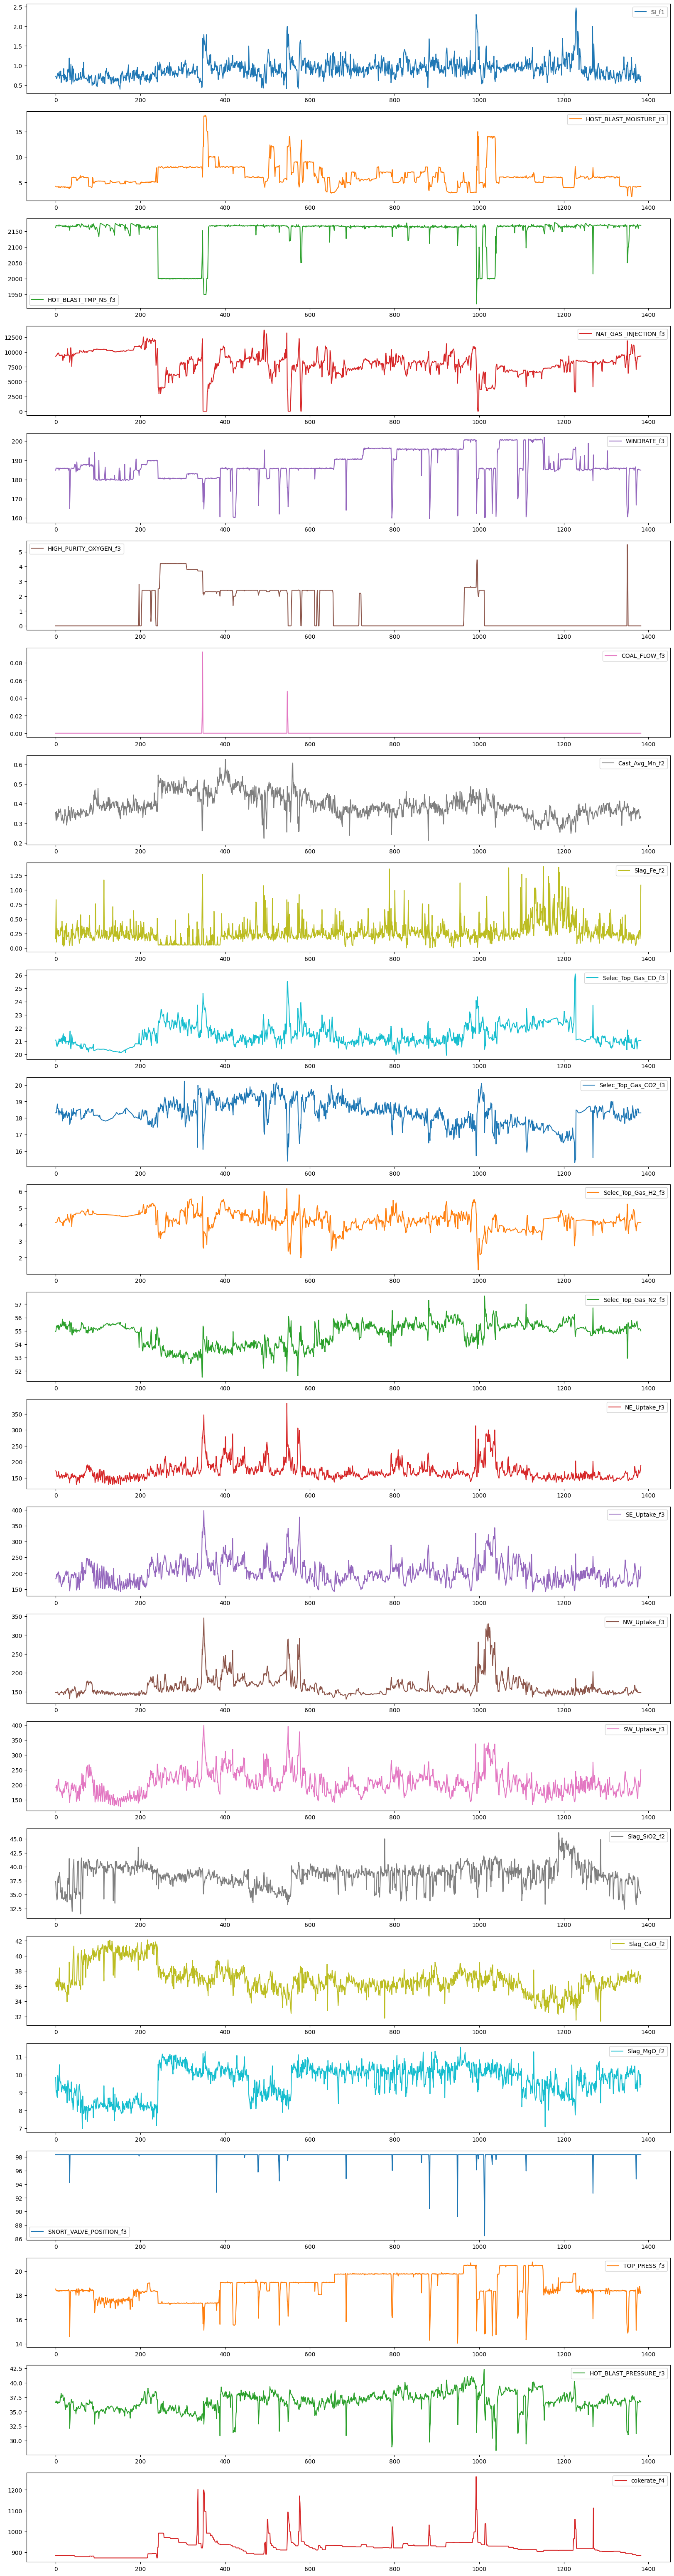

In [30]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [31]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [32]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [33]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [34]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [35]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [36]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [37]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [38]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512] or [B, 15, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [39]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [40]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [41]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [42]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x_avg = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)

        x = x + x_avg
        
        return x


In [43]:

m = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
input2 = torch.randn(8, 4, 25)

input_permute = rearrange(input2, 'b l m -> b m l')
print( input_permute.shape )
input2 = input2.unsqueeze(1)
input_permute = input_permute.unsqueeze(1)
output = m(input_permute)
output.shape


torch.Size([8, 25, 4])


torch.Size([8, 1, 25, 4])

In [44]:

inputs = torch.randn( 64, 1, 300 ) 

module = torch.nn.Conv1d(
    in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False
)

## module.weight.data = torch.full_like( module.weight.data, 0.2 )

out = module(inputs)
out.shape


torch.Size([64, 1, 300])

In [45]:

## a = torch.tensor( 42.6 )

## torch.round(a).int().item()


In [46]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size = output_size
        self.seq_length  = seq_length       ## 40 or 15
        self.input_size  = input_size

        vocab_size = 30
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512] or [40, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        #######################################################################

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # projection
        self.map_act    = nn.ReLU()

        #######################################################################

        self.map_24_512_1 = nn.Linear(25, 100)  ## [24, 512] # projection
        self.map_act1     = nn.ReLU()
        self.LayerNorm1   = nn.LayerNorm( 100 )
        self.map_24_512_2 = nn.Linear(100, 512)  ## [24, 512] # projection
        
   
        #####################################

        self.linear1_TS_int = nn.Linear(25, 15)
        self.act1_TS_int    = nn.ReLU()
        self.linear2_TS_int = nn.Linear(15, 9)
        self.act2_TS_int    = nn.ReLU()
        self.linear3_TS_int = nn.Linear(9, vocab_size)
        self.act3_TS_int    = nn.Softmax(dim=1)
        self.dropout_TS_int = nn.Dropout(0.25)
        
        #####################################

        self.conv_idx     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.bn1 = nn.BatchNorm2d(1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv_idx2     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.bn2 = nn.BatchNorm2d(1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv_idx3     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 

        self.per_conv_idx = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.per_bn1 = nn.BatchNorm2d(1)
        self.per_relu1 = nn.ReLU(inplace=True)
        self.per_conv_idx2     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.per_bn2 = nn.BatchNorm2d(1)
        self.per_relu2 = nn.ReLU(inplace=True)
        self.per_conv_idx3     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
        #####################################
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )
        ######################

        ## obj_mov_avg = moving_avg(  idx  )
        ## res         = obj_mov_avg( idx )
        ## idx = res

        #####################

        B = idx.shape[0]       ## 8 batch 
        T = idx.shape[1]       ## 40 or 15

        ############################################################
        ## add this back - rc

        ## idx = self.map_24_512( idx )       ## (8, 15, 24) goes in
        ## idx = self.map_act(    idx )
        
        ## tok_emb = idx       ## (B, 15, 512)

        ###########################################################

        idx = self.map_24_512_1( idx )       ## (8, 15, 24) goes in
        idx = self.map_act1(     idx )
        idx = self.LayerNorm1(   idx )
        idx = self.map_24_512_2( idx ) 
        
        tok_emb = idx       ## (B, 15, 512)

        ###########################################################
        ## convolutions

        idx_4d_conv = idx.unsqueeze(1)
        residual = idx_4d_conv
        conv_emb = self.conv_idx( idx_4d_conv )
        conv_emb = self.bn1(conv_emb)
        conv_emb = self.relu1(conv_emb)
        conv_emb = self.conv_idx2( conv_emb )
        conv_emb = self.bn2(conv_emb)
        conv_emb = self.relu2(conv_emb)
        conv_emb = self.conv_idx3( conv_emb)
        conv_emb = residual + conv_emb
        conv_emb = conv_emb.squeeze(1)
        

        ## Permute
        idx_4d_conv_permute = rearrange(idx_4d_conv, 'b c l m -> b c m l')
        per_residual = idx_4d_conv_permute
        per_conv_emb = self.per_conv_idx( idx_4d_conv_permute )
        per_conv_emb = self.per_bn1(per_conv_emb)
        per_conv_emb = self.per_relu1(per_conv_emb)
        per_conv_emb = self.per_conv_idx2( per_conv_emb )
        per_conv_emb = self.per_bn2( per_conv_emb )
        per_conv_emb = self.per_relu2( per_conv_emb )
        per_conv_emb = self.per_conv_idx3( per_conv_emb )
        per_conv_emb = per_residual + per_conv_emb
        per_conv_emb = rearrange(per_conv_emb, 'b c m l -> b c l m')
        per_conv_emb = per_conv_emb.squeeze(1)

        ###########################################################
        
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sines and cosines

        ###########################################################
        
        ## x = tok_emb + pos_emb + conv_emb + per_conv_emb    ## [B, T, E] or [N, 40, 512], now [N, 15, 24]

        x    = tok_emb + pos_emb + conv_emb


        ############################################################
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65]  or [N, 15, 24]
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            
        return idx
            



## Train GPT function


In [47]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )

    criterion          = nn.MSELoss()
    ## criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}
    
    train_CIVS_tr, x_means, x_standard_devs    = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        xb, yb    = get_batch( train_CIVS_tr_scaled )

        logits   = model( xb, yb )

        B, T, E  = logits.shape
        
        pred           = logits.view( B*T, E )
        y_train        = yb.view(     B*T, E )

        #######################################################
        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        ## loss = criterion( pred[:, 0], y_train[:, 0]  )
        #######################################################

        loss =  criterion( pred, y_train )      ## seems better
        
        optimizer.zero_grad( set_to_none=True )          
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [48]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ##   40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 4000   ## 5000
eval_interval     = 200     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512       ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2





## Utility Functions


In [49]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()       ## pandas to torch

    x_time_series = test_data

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [50]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae  = MAE( pred, true)
    mse  = MSE( pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse  = RSE( pred, true)

    return mae, mse, rmse, mape, mspe, rse      


In [51]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )

    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
    
    pred_20_seq = model.generate( input_test_x, 14 )

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    
    find_index = index_to_slice + 395
    SI_data    = SI_lookup_for_RNN_data_CIVS.to_numpy()[ find_index:find_index+19, 0 ]  ## real SI data is here

    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    l_real = y_real_gpt[ :, 0 ]   
    l_pred = y_pred_gpt[ :, 0 ]

    l_SI_data_real = SI_data
    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    ##################################################

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]
    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()
    l_pred_all_24_features        = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features        = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features

    ##################################################
    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    mse_eval_bins0_5 = eval_criterion(
                          torch.FloatTensor( l_pred[0:4] ), 
                          torch.FloatTensor( l_real[0:4] )
    )

    mse_eval_bins5_10 = eval_criterion(
                          torch.FloatTensor( l_pred[5:10] ), 
                          torch.FloatTensor( l_real[5:10] )
    )

    mse_eval_bins10_15 = eval_criterion(
                          torch.FloatTensor( l_pred[10:19] ), 
                          torch.FloatTensor( l_real[10:19] )
    )

    ###################################################
    
    metric_mse_loss_SI_only                = mse_eval_bins.item()
    metric_mae_mse_rmse_mape_mspe_rse_corr = metric(    l_pred, l_real ) 
    metric_rsquare_SI_only                 = r2_score(  l_real, l_pred )
    metric_rsquare_all_features            = r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
    ) 

    #####

    results_string = "mse_SI_only," + str(round( metric_mse_loss_SI_only, 4)) 
    results_string = results_string + "," + "rsquare_SI_only" + "," + str(round( metric_rsquare_SI_only, 4))
    results_string = results_string + "," + "rsquare_all_features" + "," + str(round( metric_rsquare_all_features, 4))
    several_metrics = str( metric_mae_mse_rmse_mape_mspe_rse_corr ).replace("(", "").replace(")","")
    results_string = results_string + "," + "mae_mse_rmse_mape_mspe_rse"  + "," + several_metrics
    
    ###################################################

    print( string_feature )
    print("Test MSE Loss - SI only: ",        mse_eval_bins.item()         )     ## :.4f }')
    print("Test MSE Loss - SI only 0-5: ",    mse_eval_bins0_5.item()      )     ## :.4f }')
    print("Test MSE Loss - SI only 5-10: ",   mse_eval_bins5_10.item()     )     ## :.4f }')
    print("Test MSE Loss - SI only 10-15: ",  mse_eval_bins10_15.item()    )     ## :.4f }')
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric_mae_mse_rmse_mape_mspe_rse_corr    )
    print( "Testing R**2 - SI only: ", metric_rsquare_SI_only  )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    
    print( "Testing R**2 - All features: ", metric_rsquare_all_features )

    #######################################

    x = [ i for i in range(len(l_real)) ] 

    l_SI_data_pred = []
    ## www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    www3 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3            ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ########################################

    yellow_l_SI_data_pred = []
    for i in range( len(l_pred) ):
        ww4 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1 + i, 0]
        the_curr_val = ww4 + l_pred[i]
        yellow_l_SI_data_pred.append( the_curr_val )

    ########################################
    ## Plots

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
    
    l_pred = np.roll(l_pred, -1)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    plt.plot(   x, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    train_real_plot = train_plot[:, 0]
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    
    ##########################################

    x = [ i for i in range(len(l_real)) ] 

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()

    ###########################################
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow  ## ?? rc
    fig.tight_layout()
    ax[1].legend(); plt.show()

    return results_string 


In [52]:

def function_train_rc(  train_data  ):
    
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [53]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    results_string = GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )
    return results_string


In [54]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [55]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0


## Delta of SI


In [56]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [57]:

delta_for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [58]:

delta_for_RNN_data_CIVS.insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [59]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [60]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0            0  0.719500                4.242439          2161.425209   
1            0  0.710486                4.174343          2168.238915   
2            0  0.666106                4.126144          2167.779119   
3            0  0.675145                4.120736          2166.974740   
4            0  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378         0  0.762500                4.204430          2169.361647   
1379         0  0.646000                4.208539          2169.079601   
1380         0  0.654667                4.212648          2168.797556   
1381         0  0.591667                4.217784          2168.444999   
1382         0  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [61]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [62]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000  0.719500                4.242439          2161.425209   
1     0.000000  0.710486                4.174343          2168.238915   
2    -0.044380  0.666106                4.126144          2167.779119   
3     0.009040  0.675145                4.120736          2166.974740   
4     0.101686  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378  0.109500  0.762500                4.204430          2169.361647   
1379 -0.116500  0.646000                4.208539          2169.079601   
1380  0.008667  0.654667                4.212648          2168.797556   
1381 -0.063000  0.591667                4.217784          2168.444999   
1382  0.133000  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [63]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [64]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [65]:

delta_for_RNN_data_CIVS


delta_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000                4.242439          2161.425209   
1     0.000000                4.174343          2168.238915   
2    -0.044380                4.126144          2167.779119   
3     0.009040                4.120736          2166.974740   
4     0.101686                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.109500                4.204430          2169.361647   
1379 -0.116500                4.208539          2169.079601   
1380  0.008667                4.212648          2168.797556   
1381 -0.063000                4.217784          2168.444999   
1382  0.133000                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       14

In [66]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [67]:


delta_for_RNN_data_CIVS .insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [68]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000           0                4.242439          2161.425209   
1     0.000000           0                4.174343          2168.238915   
2    -0.044380           0                4.126144          2167.779119   
3     0.009040           0                4.120736          2166.974740   
4     0.101686           0                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500           0                4.204430          2169.361647   
1379 -0.116500           0                4.208539          2169.079601   
1380  0.008667           0                4.212648          2168.797556   
1381 -0.063000           0                4.217784          2168.444999   
1382  0.133000           0                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [69]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [70]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [71]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000    0.000000                4.242439          2161.425209   
1     0.000000    0.000000                4.174343          2168.238915   
2    -0.044380    0.000000                4.126144          2167.779119   
3     0.009040    0.000000                4.120736          2166.974740   
4     0.101686    0.000000                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500    0.004444                4.204430          2169.361647   
1379 -0.116500    0.008900                4.208539          2169.079601   
1380  0.008667   -0.037618                4.212648          2168.797556   
1381 -0.063000   -0.014340                4.217784          2168.444999   
1382  0.133000    0.011422                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [72]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [73]:

training_chunk = 400


In [74]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [75]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


692

In [76]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
692
1107


In [77]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [78]:

sliced_chunk_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
692  -0.024616   -0.009838                5.000182          2164.119816   
693  -0.105080   -0.031752                4.986878          2163.413204   
694  -0.102769   -0.029116                4.982354          2161.252589   
695   0.155495   -0.043870                4.918762          2162.285661   
696   0.372315    0.030434                4.555009          2168.003389   
...        ...         ...                     ...                  ...   
1102 -0.174154   -0.006490                5.902598          2166.453099   
1103 -0.059000   -0.022936                6.070870          2154.499816   
1104  0.044000    0.000844                6.071686          2152.103509   
1105  0.046508   -0.000549                5.965857          2167.683557   
1106 -0.032502   -0.002186                5.995164          2164.897226   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
692             7255.312245   190.327780                    0.0           0.0   
693             6997.403499   190.531687                    0.0           0.0   
694             6834.450096   190.462549                    0.0           0.0   
695             7187.959876   190.641074                    0.0           0.0   
696             7157.012573   190.603827                    0.0           0.0   
...                     ...          ...                    ...           ...   
1102            6372.101760   185.617748                    0.0           0.0   
1103            6424.088888   184.699350                    0.0           0.0   
1104            6421.085779   184.833279                    0.0           0.0   
1105            6955.119849   199.882157                    0.0           0.0   
1106            6909.989635   200.737367                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
692            0.356        0.19            20.941358             18.667640   
693            0.380        0.18            20.931160             18.330533   
694            0.238        0.25            20.796026             18.847816   
695            0.353        0.20            20.845952             18.867027   
696            0.420        0.34            20.916699             18.688635   
...              ...         ...                  ...                   ...   
1102           0.374        0.31            21.984535             17.665509   
1103           0.378        0.33            22.127519             17.576216   
1104           0.351        0.24            22.124072             17.574704   
1105           0.335        0.41            22.155503             17.597741   
1106           0.353        0.31            22.134660             17.713546   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
692              3.675535            55.584139    183.563798    241.022026   
693              3.756925            55.814635    160.416529    213.279233   
694              3.747831            55.691058    167.818070    211.914296   
695              3.712492            55.503543    181.475390    199.527045   
696              3.777491            55.591220    172.711613    219.696165   
...                   ...                  ...           ...           ...   
1102             3.688015            55.444439    172.812301    217.170584   
1103             3.719221            55.364523    165.042808    214.017585   
1104             3.719685            55.385750    163.838193    189.276341   
1105             3.697258            55.129640    178.178583    233.325793   
1106             3.704100            55.220010    167.122098    212.338259   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
692     144.677645    259.301646     38.790001    37.759998        10.78   
693     145.207231    218.754776     39.500000    37.480000        10.59   
694     144.793475


## Train and test


In [79]:

n = block_size

print( n )


15


In [80]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [81]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [82]:

test_CIVS 


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
1092 -0.063097   -0.000726                6.071224          2169.415968   
1093  0.105454    0.001713                6.023933          2167.676591   
1094 -0.193800    0.000903                5.998741          2164.131505   
1095  0.060443    0.012653                6.003077          2170.791880   
1096 -0.016133    0.008550                6.010200          2167.271277   
1097  0.029122    0.005341                6.030868          2167.851815   
1098 -0.065870    0.002490                6.060633          2165.081413   
1099 -0.046622   -0.018327                6.060430          2167.929128   
1100  0.063711   -0.004260                5.974090          2167.327876   
1101  0.172946    0.004615                6.040246          2167.131603   
1102 -0.174154   -0.006490                5.902598          2166.453099   
1103 -0.059000   -0.022936                6.070870          2154.499816   
1104  0.044000    0.000844                6.071686          2152.103509   
1105  0.046508   -0.000549                5.965857          2167.683557   
1106 -0.032502   -0.002186                5.995164          2164.897226   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
1092            5811.289681   170.285348                    0.0           0.0   
1093            5740.248692   172.938575                    0.0           0.0   
1094            6060.821028   181.163715                    0.0           0.0   
1095            6179.512611   185.384525                    0.0           0.0   
1096            6188.073681   185.823945                    0.0           0.0   
1097            6273.717931   185.738631                    0.0           0.0   
1098            6267.457466   185.857995                    0.0           0.0   
1099            6326.886386   185.689816                    0.0           0.0   
1100            6311.601416   185.585573                    0.0           0.0   
1101            6366.363774   185.706293                    0.0           0.0   
1102            6372.101760   185.617748                    0.0           0.0   
1103            6424.088888   184.699350                    0.0           0.0   
1104            6421.085779   184.833279                    0.0           0.0   
1105            6955.119849   199.882157                    0.0           0.0   
1106            6909.989635   200.737367                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
1092           0.385        0.25            21.605822             17.770153   
1093           0.380        0.25            21.775375             17.734010   
1094           0.373        0.19            21.883130             17.792900   
1095           0.378        0.24            21.930522             17.724257   
1096           0.386        0.18            22.018281             17.658692   
1097           0.379        0.23            21.975632             17.590230   
1098           0.380        1.04            22.070908             17.593675   
1099           0.377        0.30            22.111475             17.624997   
1100           0.387        0.28            22.080030             17.656436   
1101           0.367        1.27            22.185546             17.673989   
1102           0.374        0.31            21.984535             17.665509   
1103           0.378        0.33            22.127519             17.576216   
1104           0.351        0.24            22.124072             17.574704   
1105           0.335        0.41            22.155503             17.597741   
1106           0.353        0.31            22.134660             17.713546   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
1092             3.529605            56.036788    165.904354    209.935298   
1093             3.513301            55.840899    168.172304    235.999730   
1094     

In [83]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [84]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


In [85]:
'''
print(idx.shape)
        vals, indeces = torch.max( idx, dim=2  )
        print( vals.shape )
        print( indeces )
        print(idx.shape)
        input()
'''

'\nprint(idx.shape)\n        vals, indeces = torch.max( idx, dim=2  )\n        print( vals.shape )\n        print( indeces )\n        print(idx.shape)\n        input()\n'

torch.Size([100, 25])
0 train loss =  1.0992182493209839
500 train loss =  0.007865934632718563
1000 train loss =  0.004579845815896988
1500 train loss =  0.0031428535003215075
2000 train loss =  0.0018492332892492414
2500 train loss =  0.001772603951394558
3000 train loss =  0.0015400238335132599
3500 train loss =  0.0012219541240483522


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


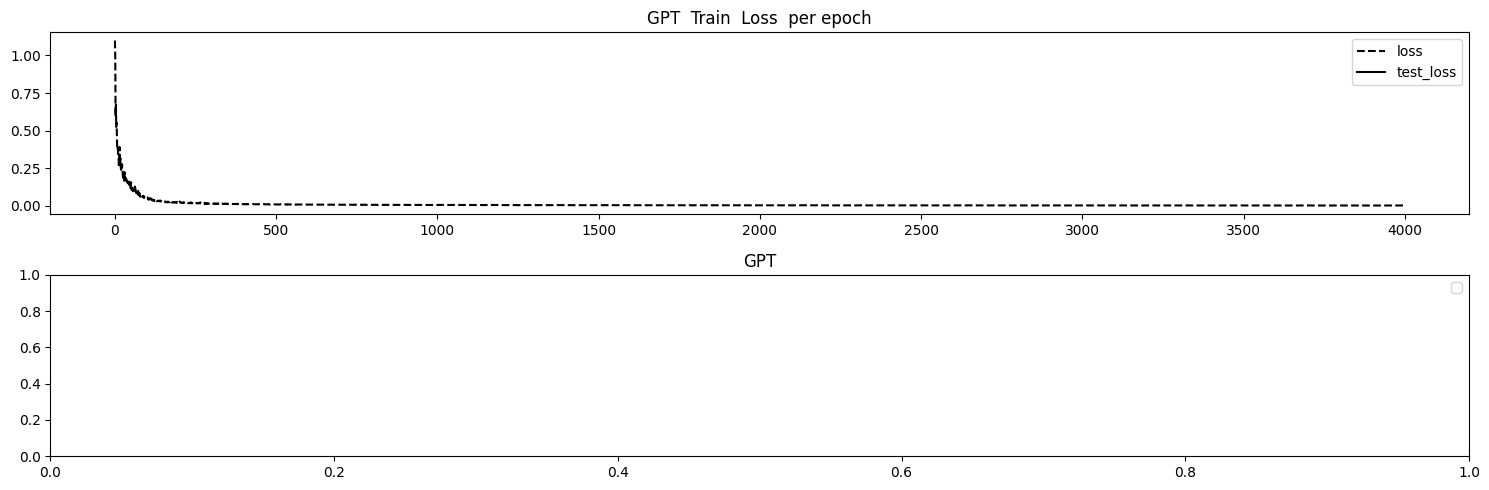

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.02200278639793396
Test MSE Loss - SI only 0-5:  0.0330318883061409
Test MSE Loss - SI only 5-10:  0.03048761561512947
Test MSE Loss - SI only 10-15:  0.012421609833836555
mae, mse, rmse, mape, mspe, rse, corr
(0.11265151, 0.022002785, 0.14833336, 1.3855922, 2.6254497, 1.5352296)
Testing R**2 - SI only:  -1.356930238153029
Testing R**2 - SI only:  -1.356930238153029
Testing R**2 - All features:  0.9814443702495086


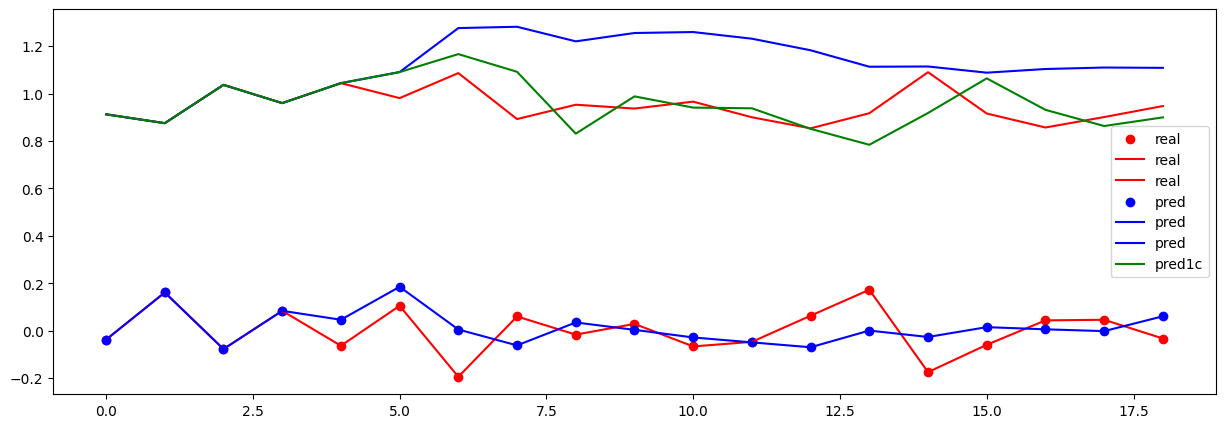

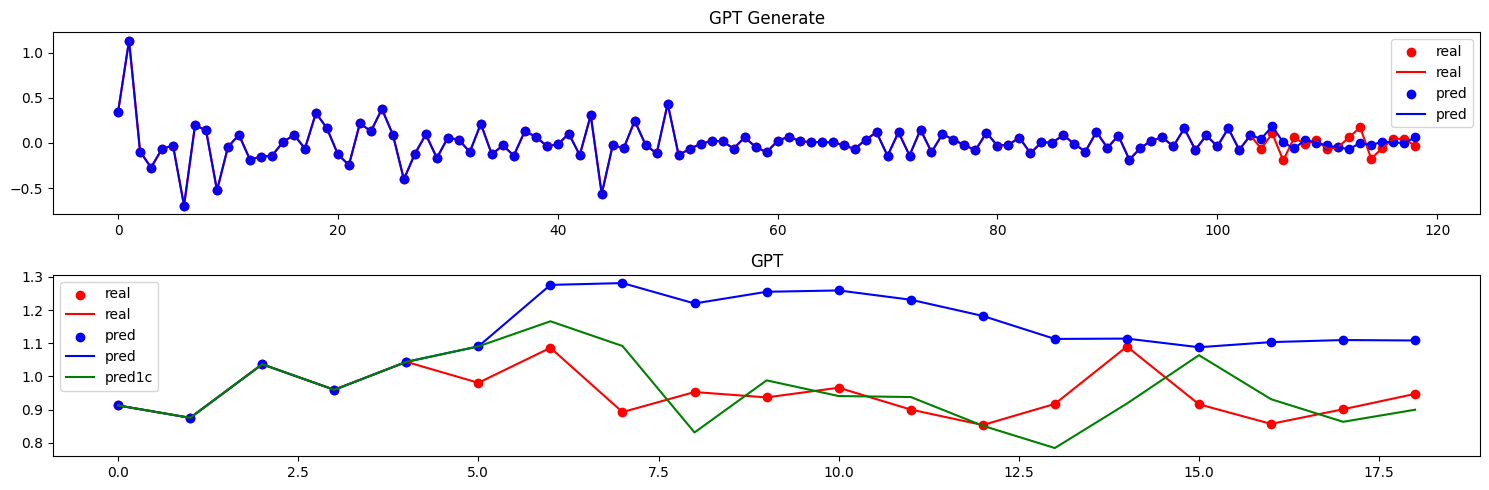

In [86]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.200424075126648
500 train loss =  0.014050746336579323
1000 train loss =  0.0072691733948886395
1500 train loss =  0.005147706717252731
2000 train loss =  0.0033264257945120335
2500 train loss =  0.002940906910225749
3000 train loss =  0.0021738328505307436
3500 train loss =  0.0022867880761623383


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


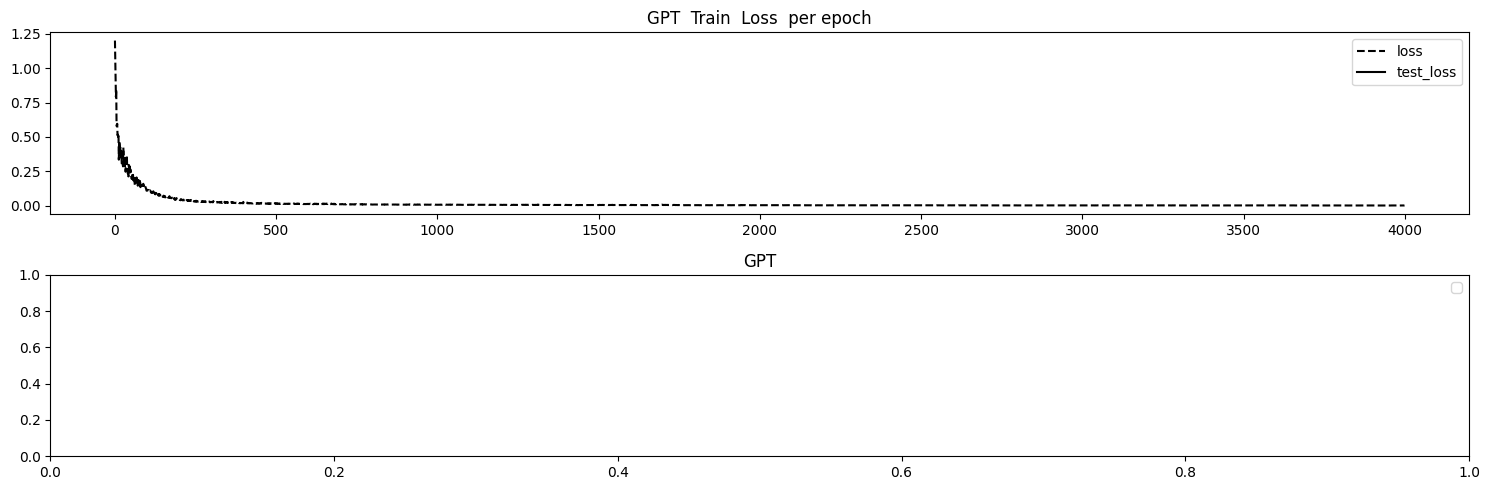

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.015997398644685745
Test MSE Loss - SI only 0-5:  0.0330318883061409
Test MSE Loss - SI only 5-10:  0.014949023723602295
Test MSE Loss - SI only 10-15:  0.008376117795705795
mae, mse, rmse, mape, mspe, rse, corr
(0.10392978, 0.0159974, 0.12648083, 1.3692237, 2.4630945, 1.309059)
Testing R**2 - SI only:  -0.7136352812907047
Testing R**2 - SI only:  -0.7136352812907047
Testing R**2 - All features:  0.9878306954127019


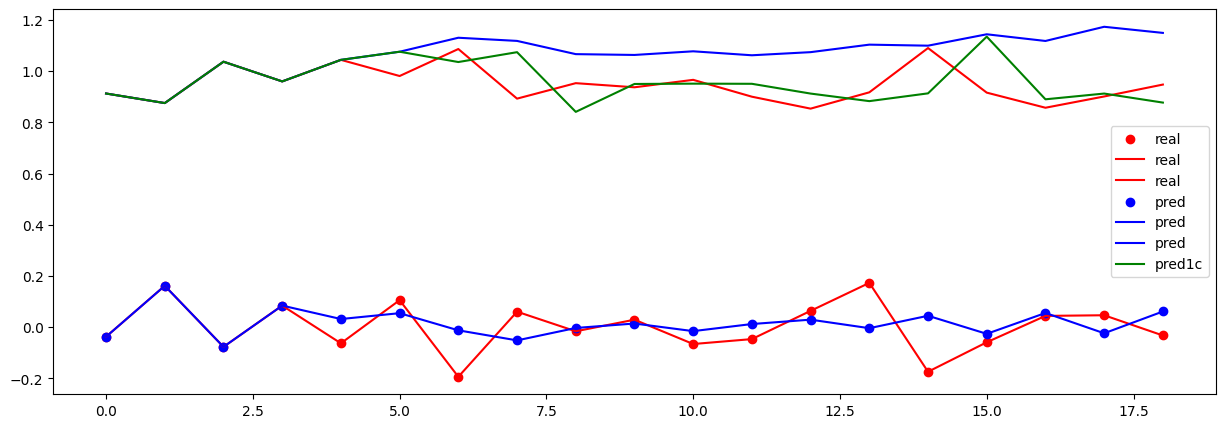

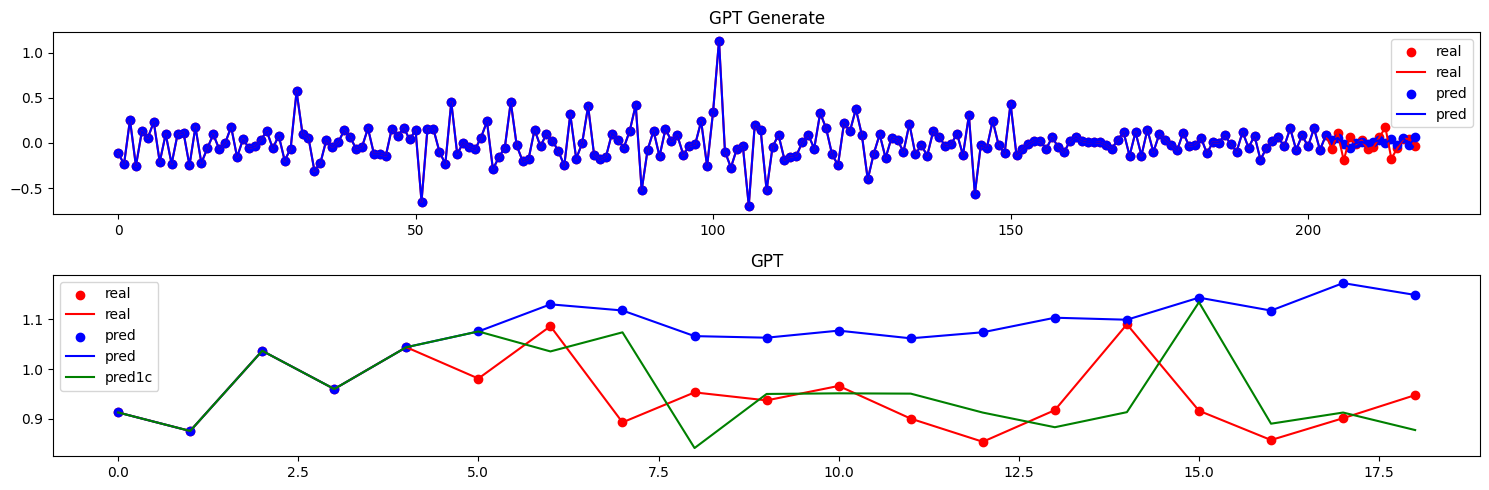

In [87]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.3968337774276733
500 train loss =  0.02062189020216465
1000 train loss =  0.009351195767521858
1500 train loss =  0.006391461472958326
2000 train loss =  0.005350046791136265
2500 train loss =  0.0041497438214719296
3000 train loss =  0.0028632525354623795
3500 train loss =  0.0022478210739791393


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


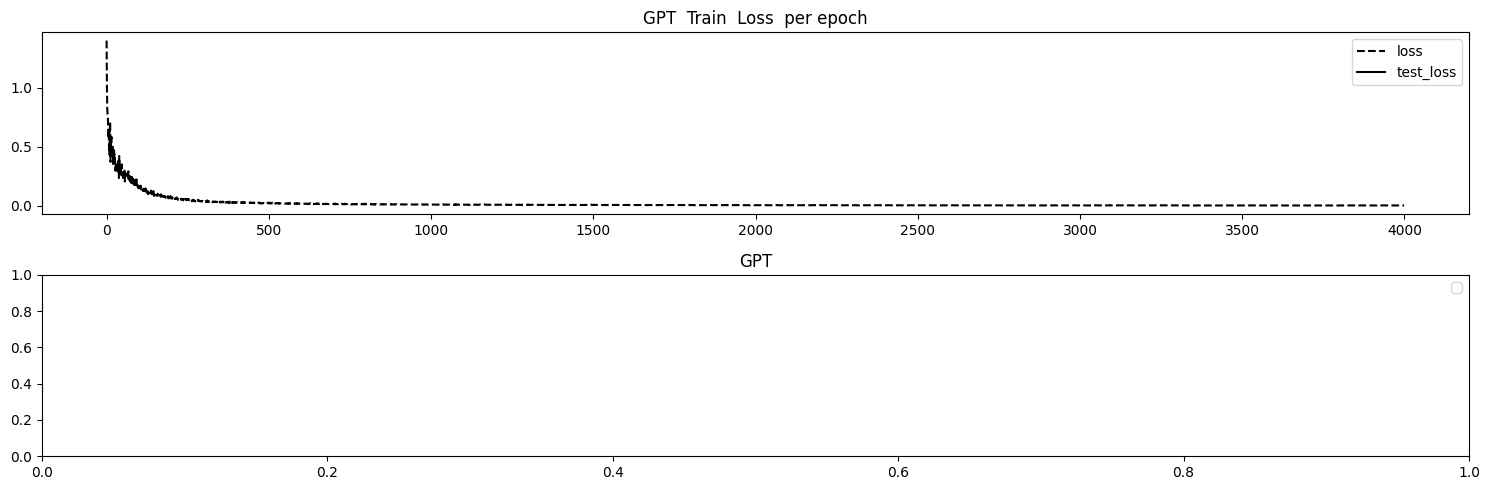

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.017843211069703102
Test MSE Loss - SI only 0-5:  0.0330318883061409
Test MSE Loss - SI only 5-10:  0.018622983247041702
Test MSE Loss - SI only 10-15:  0.010231750085949898
mae, mse, rmse, mape, mspe, rse, corr
(0.111226834, 0.017843213, 0.1335785, 1.5186629, 3.2533855, 1.3825188)
Testing R**2 - SI only:  -0.9113582287251292
Testing R**2 - SI only:  -0.9113582287251292
Testing R**2 - All features:  0.9144016652089021


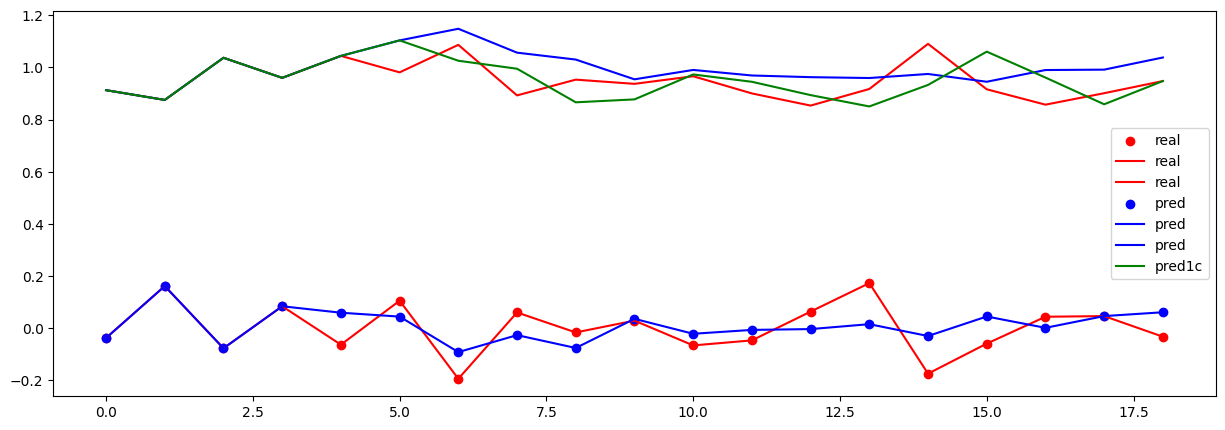

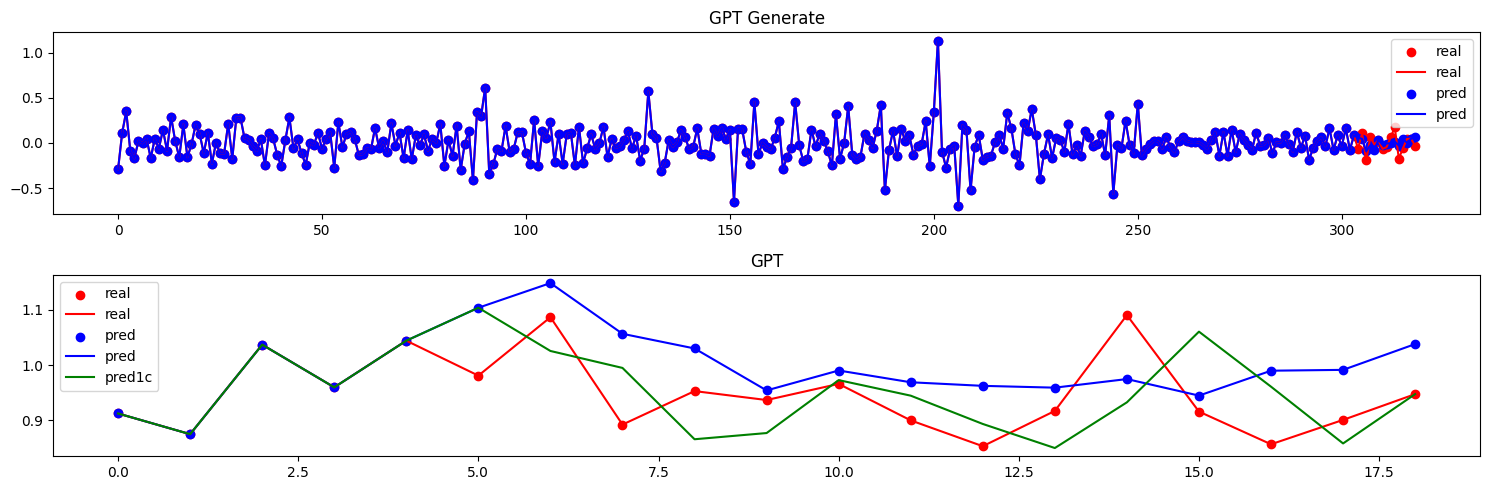

In [88]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.679406762123108
500 train loss =  0.026764072477817535
1000 train loss =  0.01316076796501875
1500 train loss =  0.007695346605032682
2000 train loss =  0.005898099858313799
2500 train loss =  0.004651149269193411
3000 train loss =  0.003267592051997781
3500 train loss =  0.00320429471321404


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


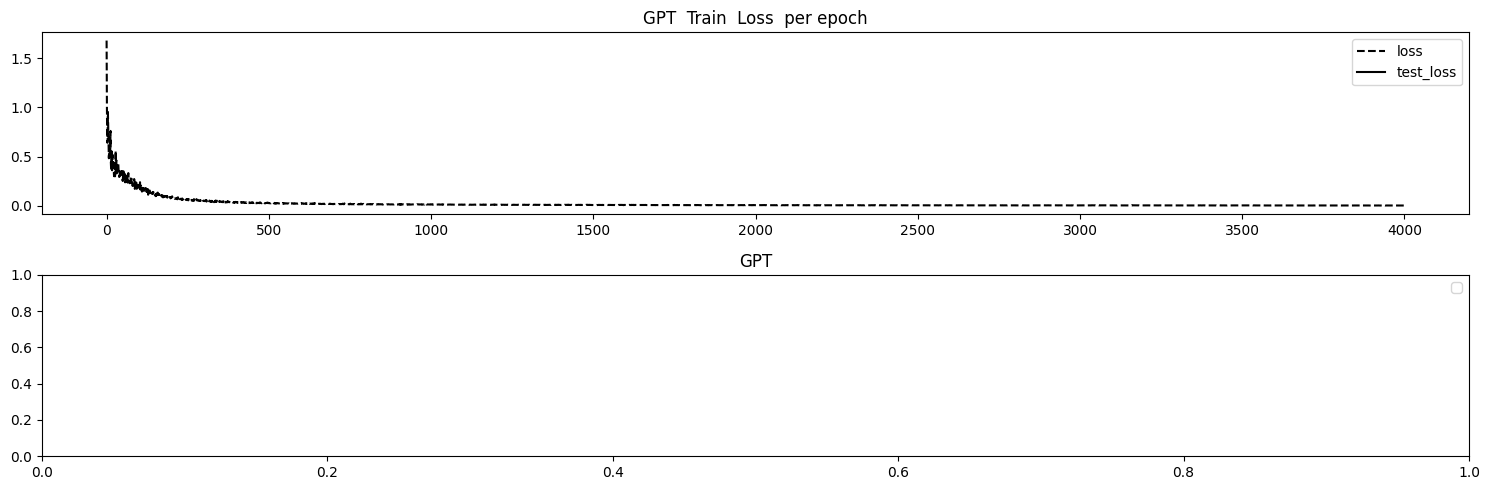

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.01721644029021263
Test MSE Loss - SI only 0-5:  0.0330318883061409
Test MSE Loss - SI only 5-10:  0.014712234027683735
Test MSE Loss - SI only 10-15:  0.011081202886998653
mae, mse, rmse, mape, mspe, rse, corr
(0.11088012, 0.01721644, 0.13121143, 1.4861064, 2.8791425, 1.3580202)
Testing R**2 - SI only:  -0.844218721272677
Testing R**2 - SI only:  -0.844218721272677
Testing R**2 - All features:  0.9223658110028792


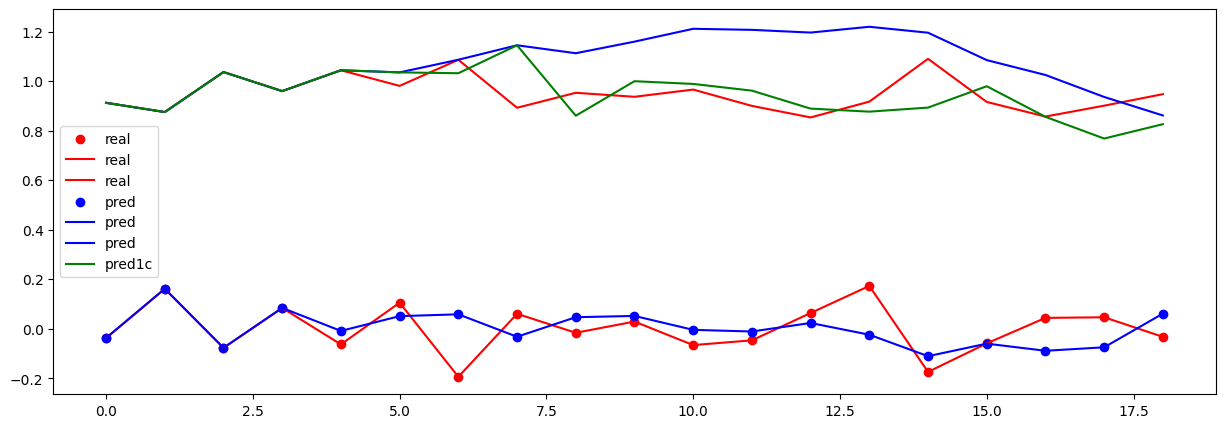

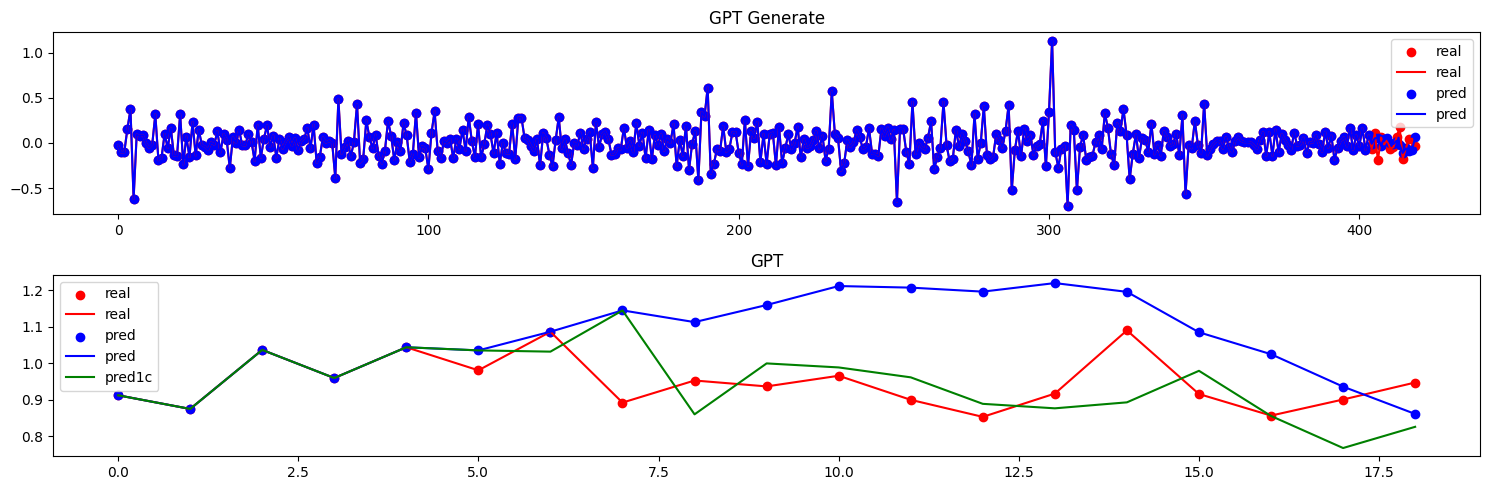

In [89]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 2


In [90]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





1383
808
1223
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.0474494695663452
500 train loss =  0.00841529667377472
1000 train loss =  0.004866422154009342
1500 train loss =  0.0032780799083411694
2000 train loss =  0.002333817072212696
2500 train loss =  0.0017184728058055043
3000 train loss =  0.0015196886379271746
3500 train loss =  0.001111305202357471


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


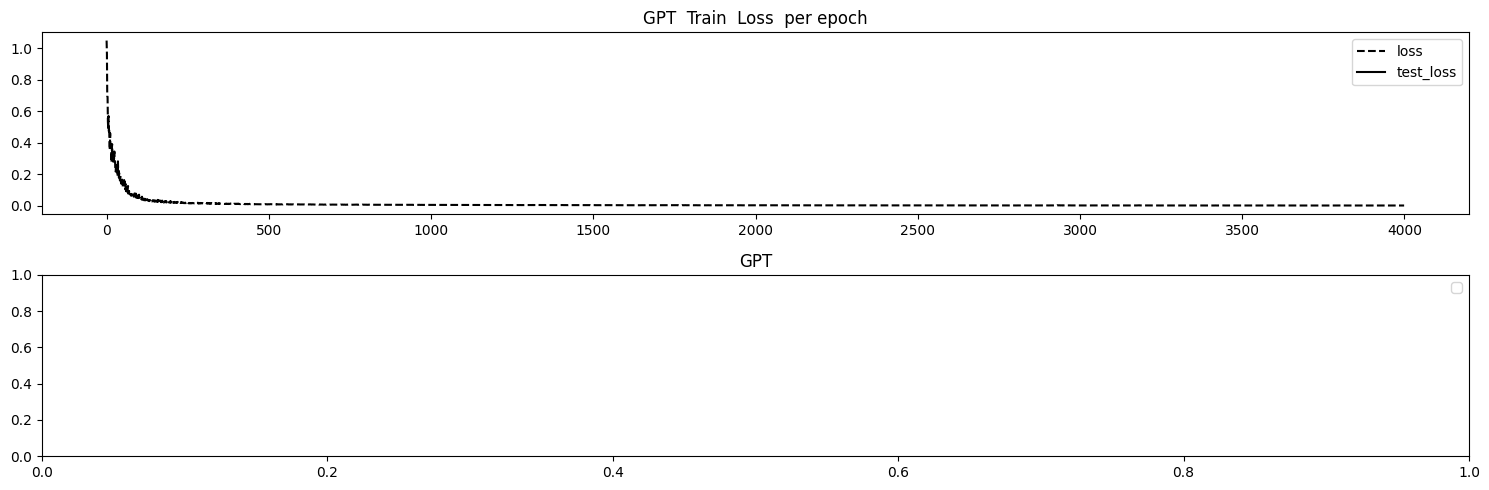

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04480775445699692
Test MSE Loss - SI only 0-5:  0.08854148536920547
Test MSE Loss - SI only 5-10:  0.015011084266006947
Test MSE Loss - SI only 10-15:  0.04497538506984711
mae, mse, rmse, mape, mspe, rse, corr
(0.17937984, 0.04480776, 0.21167843, 2.2621338, 22.916353, 1.1598532)
Testing R**2 - SI only:  -0.3452592725029757
Testing R**2 - SI only:  -0.3452592725029757
Testing R**2 - All features:  0.9865285443142011


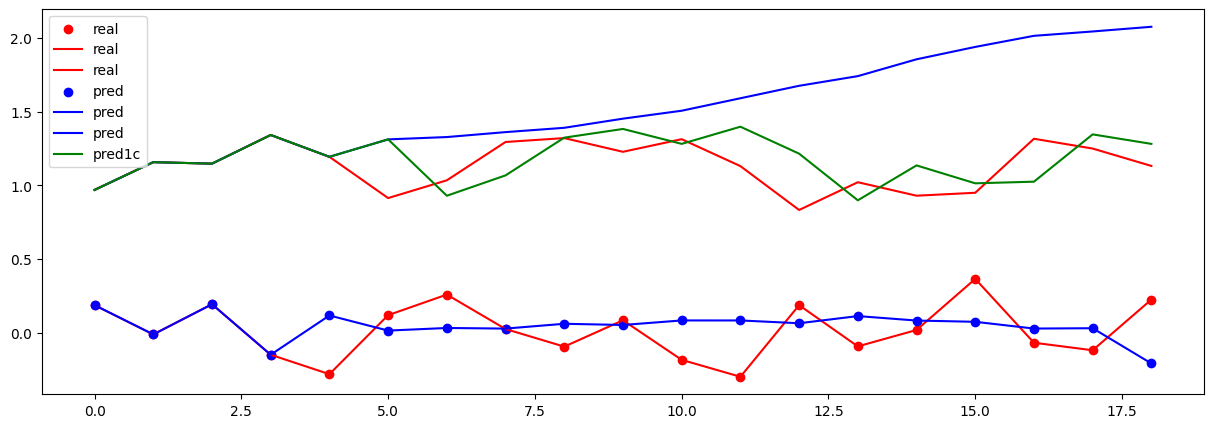

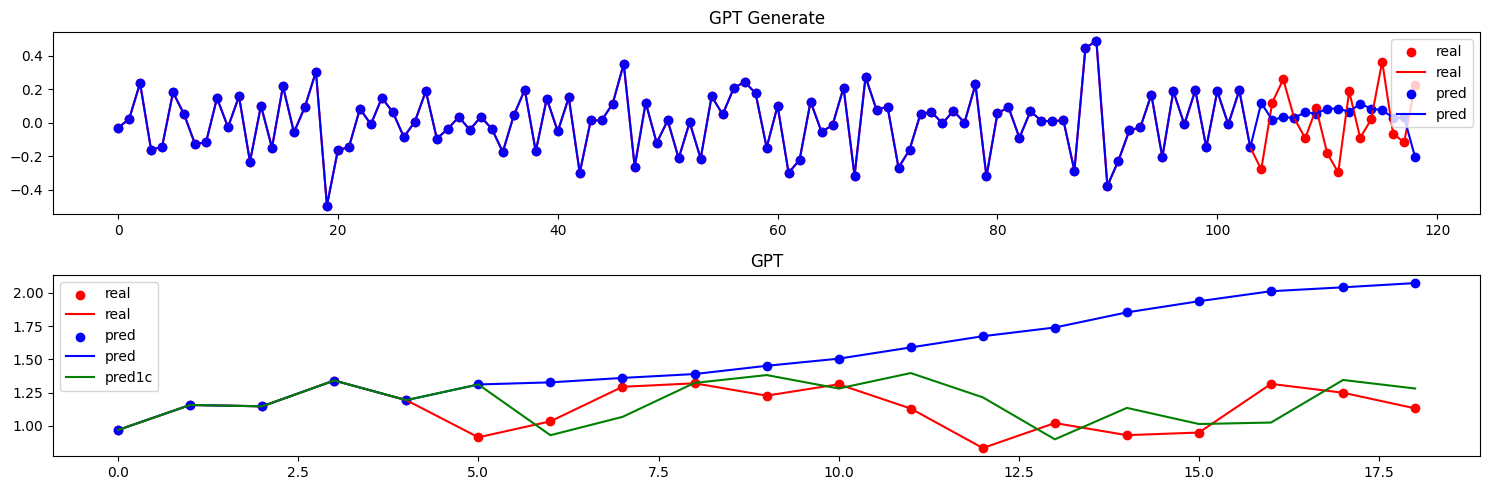

In [91]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([200, 25])
0 train loss =  0.8887233138084412
500 train loss =  0.015825612470507622
1000 train loss =  0.0070333825424313545
1500 train loss =  0.005043277982622385
2000 train loss =  0.003343911375850439
2500 train loss =  0.0026325152721256018
3000 train loss =  0.0021413296926766634
3500 train loss =  0.001987369731068611


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


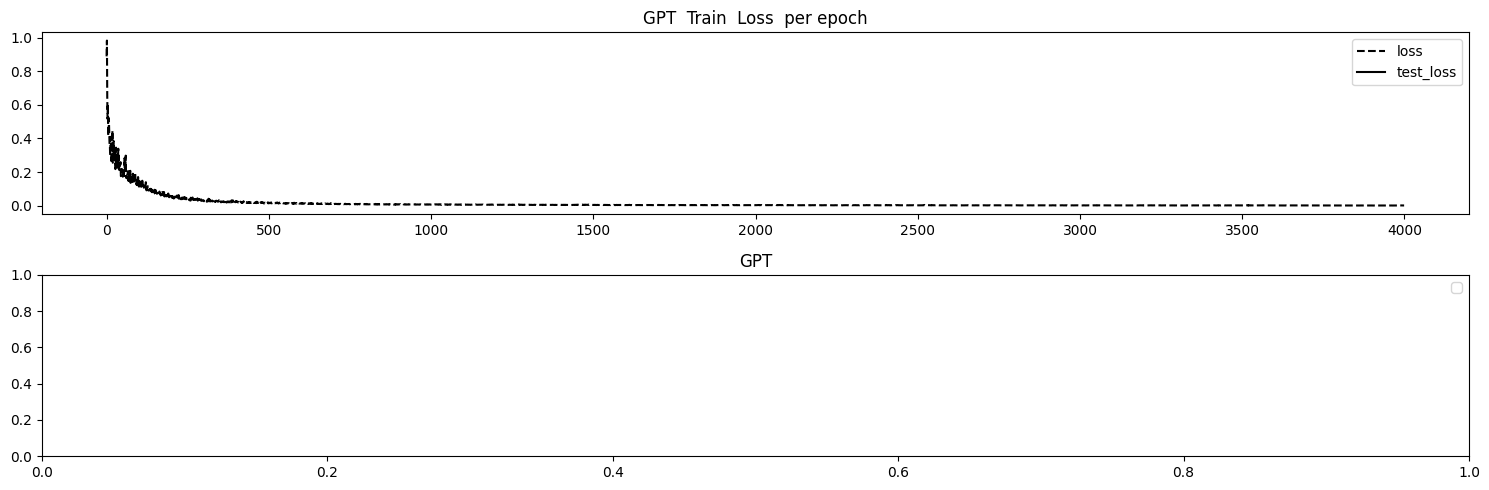

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.049207188189029694
Test MSE Loss - SI only 0-5:  0.08854148536920547
Test MSE Loss - SI only 5-10:  0.026987433433532715
Test MSE Loss - SI only 10-15:  0.04760954529047012
mae, mse, rmse, mape, mspe, rse, corr
(0.1817, 0.04920719, 0.22182693, 2.1408215, 22.009344, 1.2154601)
Testing R**2 - SI only:  -0.4773430490900008
Testing R**2 - SI only:  -0.4773430490900008
Testing R**2 - All features:  0.9668756615332672


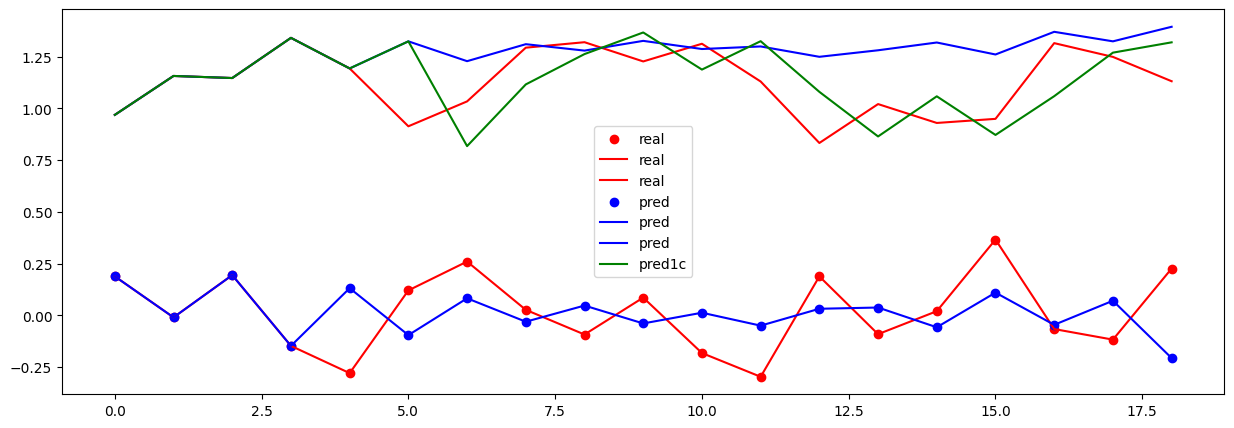

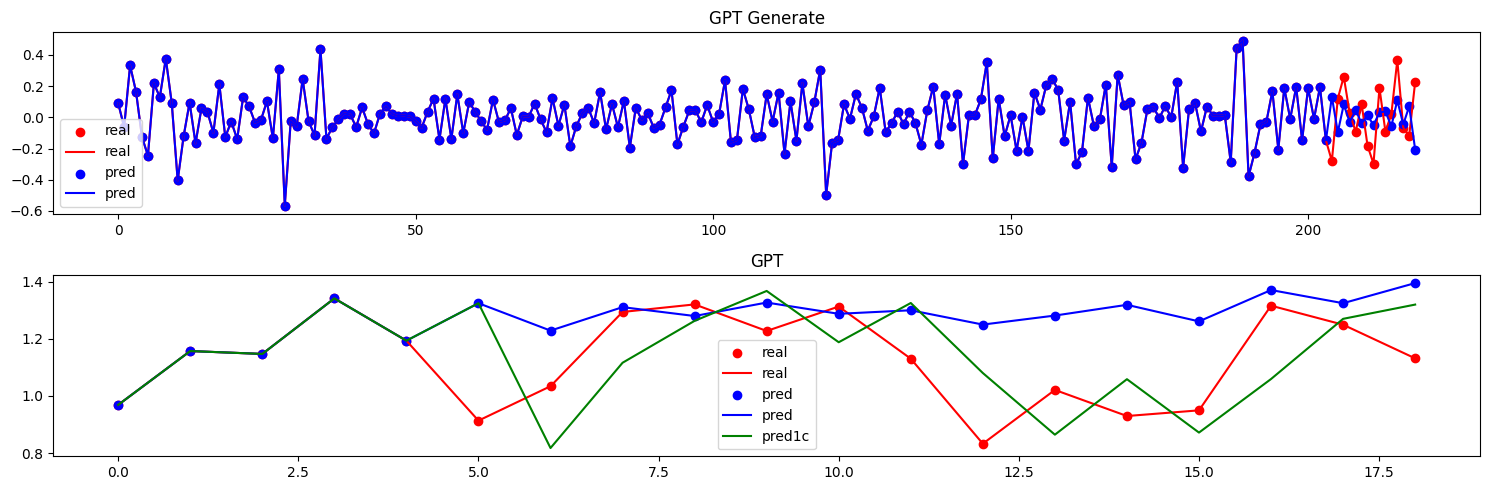

In [92]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([300, 25])
0 train loss =  1.0064899921417236
500 train loss =  0.02585388720035553
1000 train loss =  0.010646454058587551
1500 train loss =  0.00756539823487401
2000 train loss =  0.004621563013643026
2500 train loss =  0.0035532976035028696
3000 train loss =  0.003429278265684843
3500 train loss =  0.003181631676852703


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


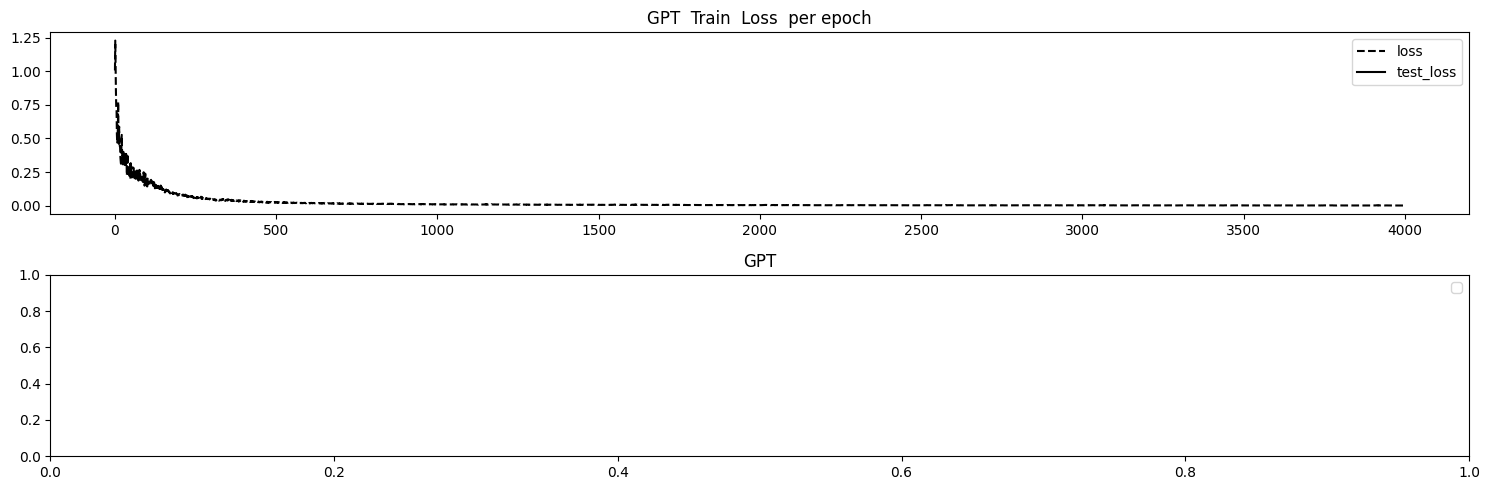

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04752281308174133
Test MSE Loss - SI only 0-5:  0.08854148536920547
Test MSE Loss - SI only 5-10:  0.02434486337006092
Test MSE Loss - SI only 10-15:  0.04552174732089043
mae, mse, rmse, mape, mspe, rse, corr
(0.18884887, 0.047522813, 0.21799728, 2.1589634, 21.856195, 1.1944761)
Testing R**2 - SI only:  -0.4267733895030541
Testing R**2 - SI only:  -0.4267733895030541
Testing R**2 - All features:  0.9857589483248503


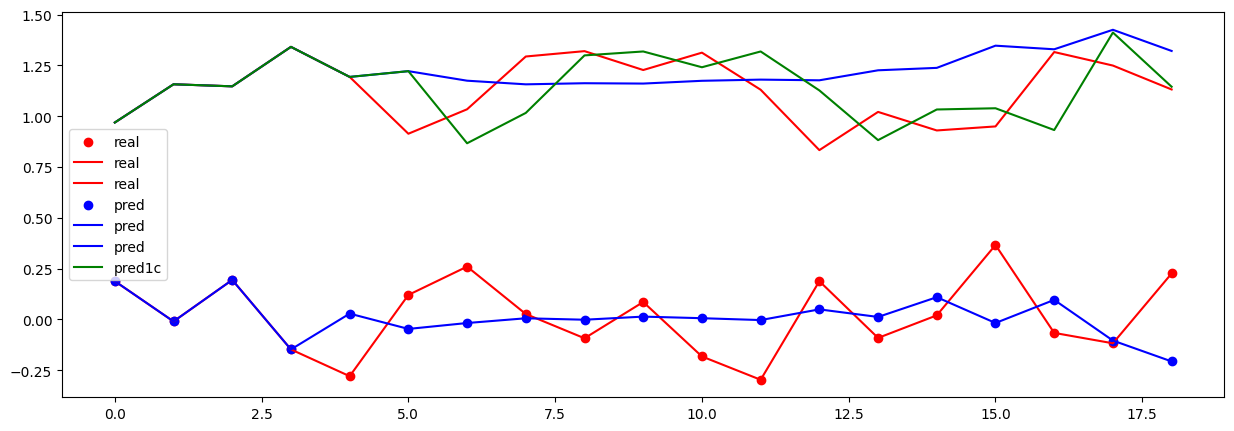

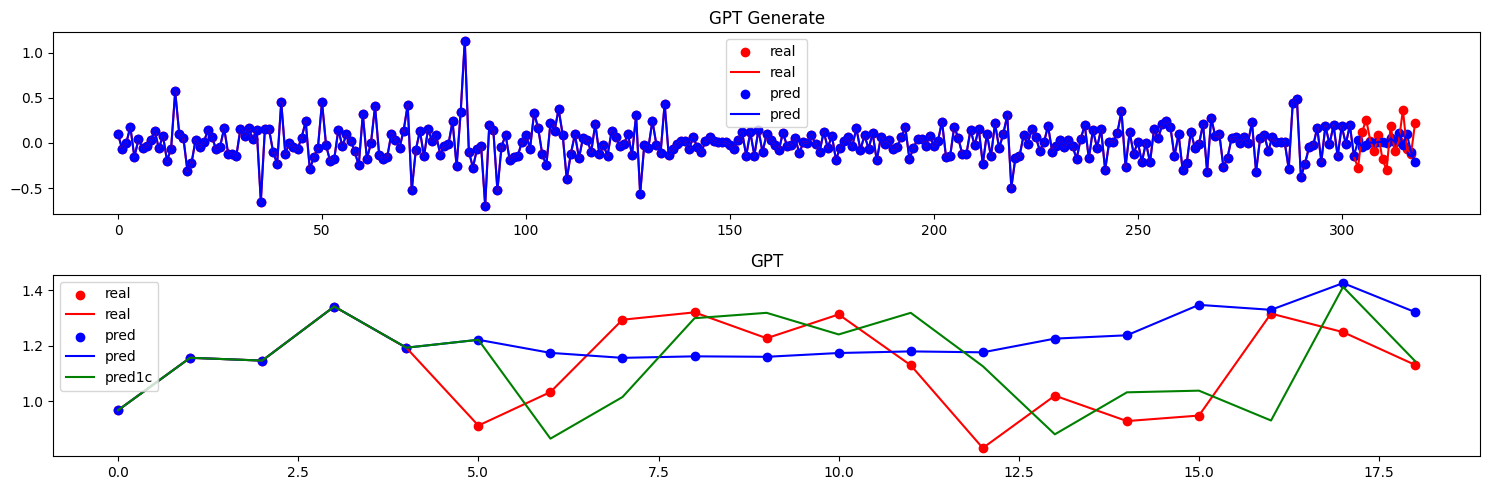

In [93]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.4153109788894653
500 train loss =  0.027478095144033432
1000 train loss =  0.011234982870519161
1500 train loss =  0.008271969854831696
2000 train loss =  0.005276449024677277
2500 train loss =  0.004251066595315933
3000 train loss =  0.0032180564012378454
3500 train loss =  0.0032544161658734083


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


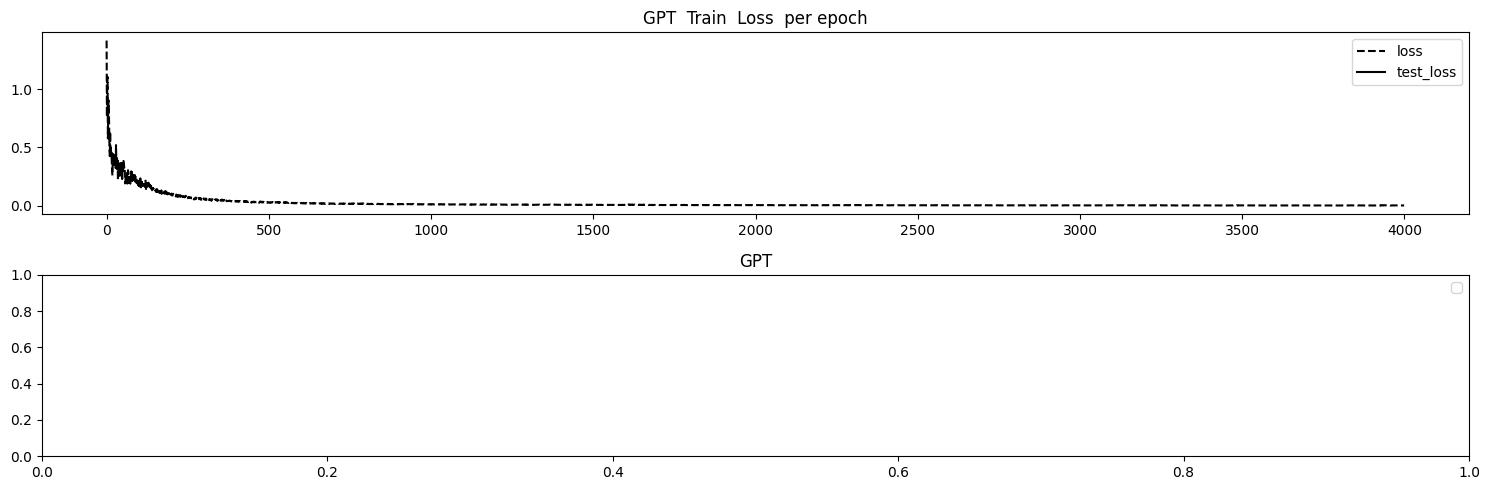

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05289187654852867
Test MSE Loss - SI only 0-5:  0.08854148536920547
Test MSE Loss - SI only 5-10:  0.01845850609242916
Test MSE Loss - SI only 10-15:  0.060126617550849915
mae, mse, rmse, mape, mspe, rse, corr
(0.19850357, 0.052891877, 0.22998235, 2.4270163, 23.588596, 1.2601461)
Testing R**2 - SI only:  -0.587968010007309
Testing R**2 - SI only:  -0.587968010007309
Testing R**2 - All features:  0.9900492117323105


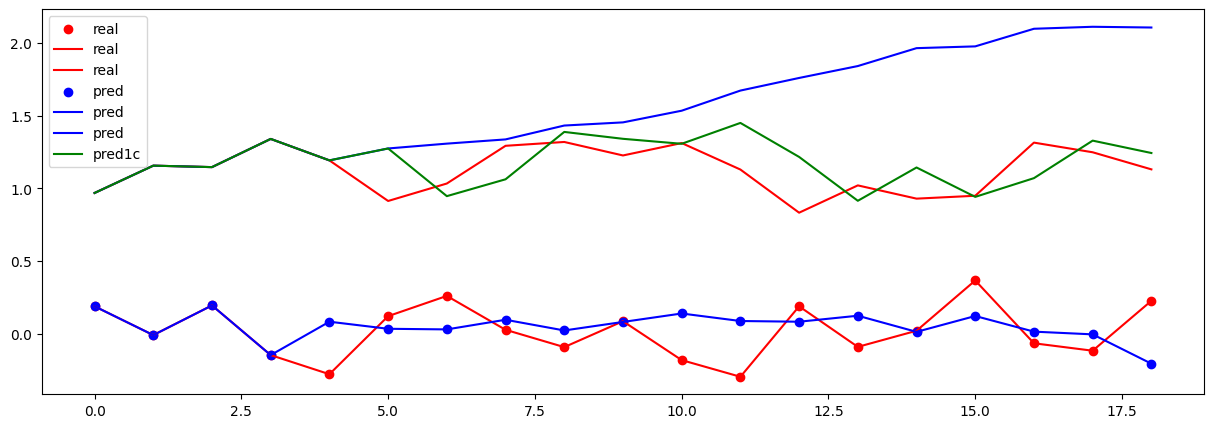

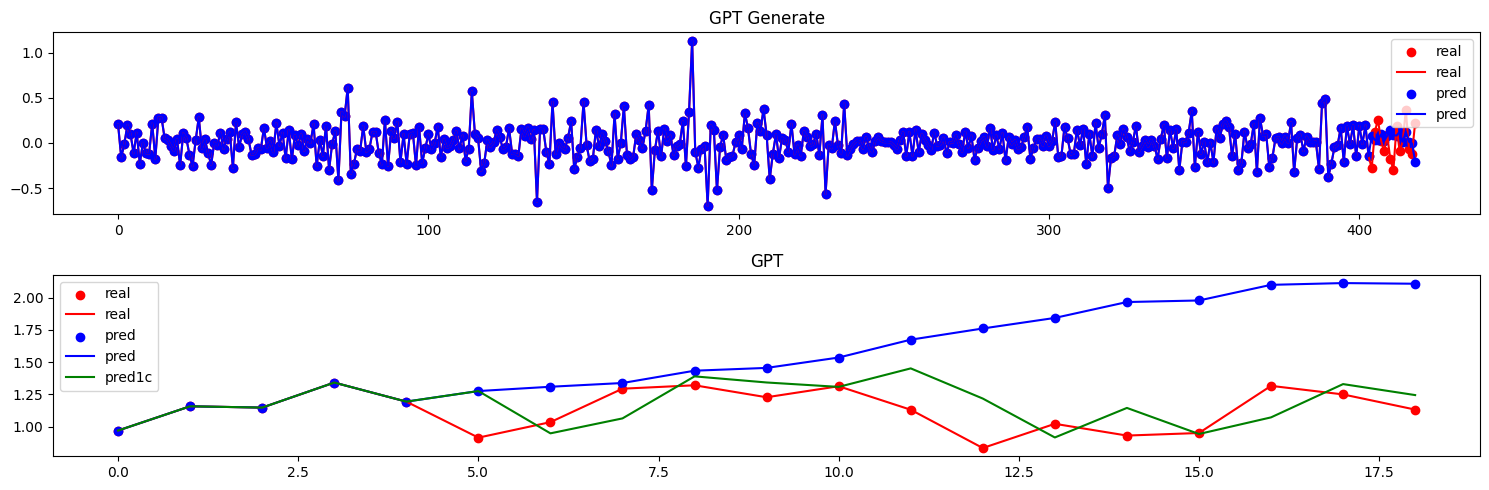

In [94]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 3


In [95]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



1383
472
887
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.2570552825927734
500 train loss =  0.008917941711843014
1000 train loss =  0.005222716368734837
1500 train loss =  0.003467211266979575
2000 train loss =  0.0024708376731723547
2500 train loss =  0.0018872899236157537
3000 train loss =  0.0014770354609936476
3500 train loss =  0.0011133012594655156


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


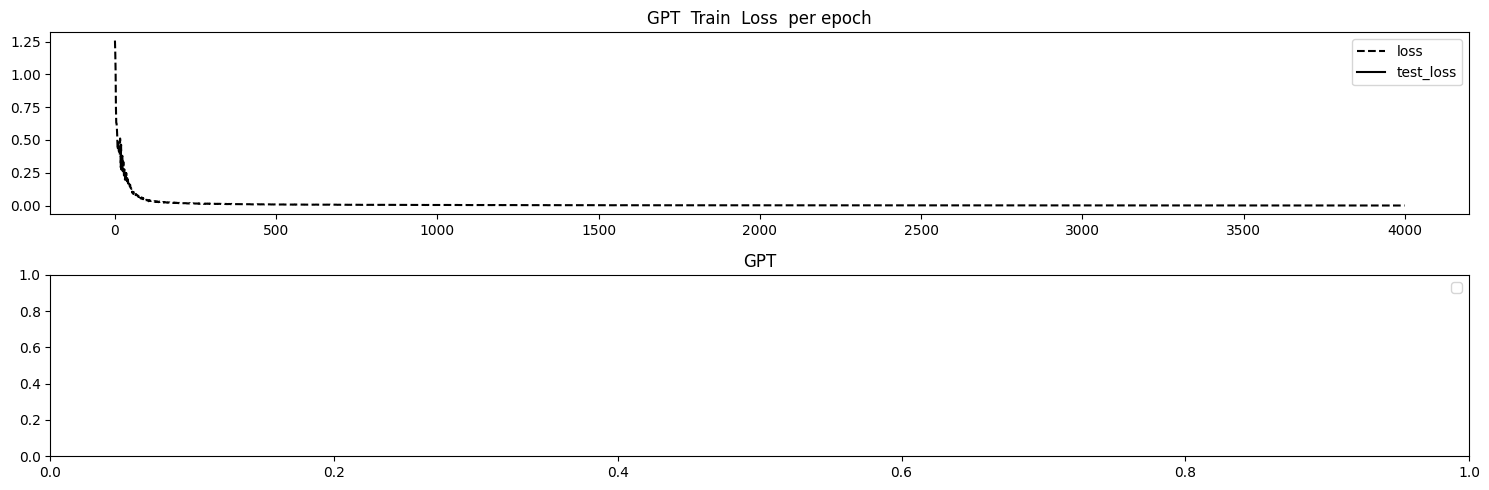

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.07044491916894913
Test MSE Loss - SI only 0-5:  0.02413731813430786
Test MSE Loss - SI only 5-10:  0.0514536015689373
Test MSE Loss - SI only 10-15:  0.0854322761297226
mae, mse, rmse, mape, mspe, rse, corr
(0.22223708, 0.07044492, 0.26541463, 8.55091, 948.8459, 1.0485789)
Testing R**2 - SI only:  -0.09951756610519968
Testing R**2 - SI only:  -0.09951756610519968
Testing R**2 - All features:  0.9859239154241144


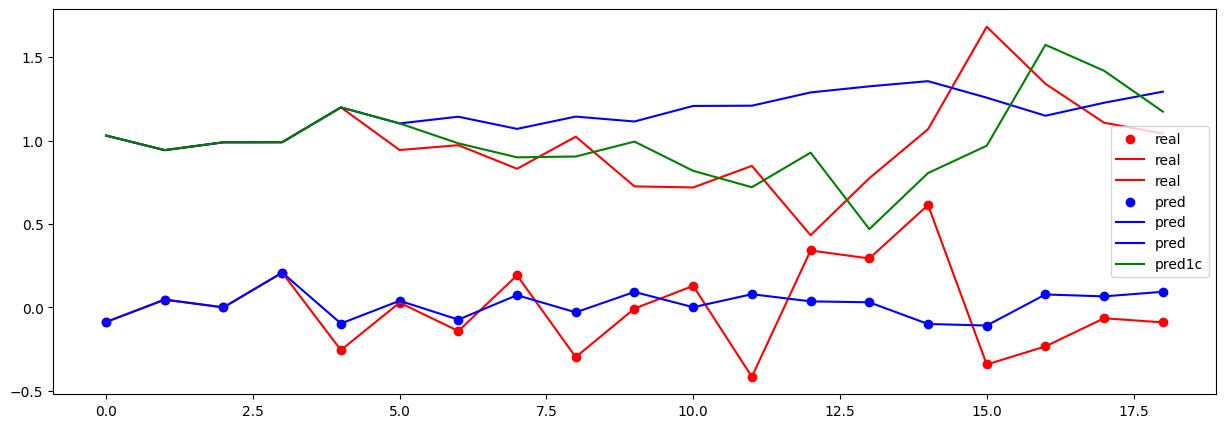

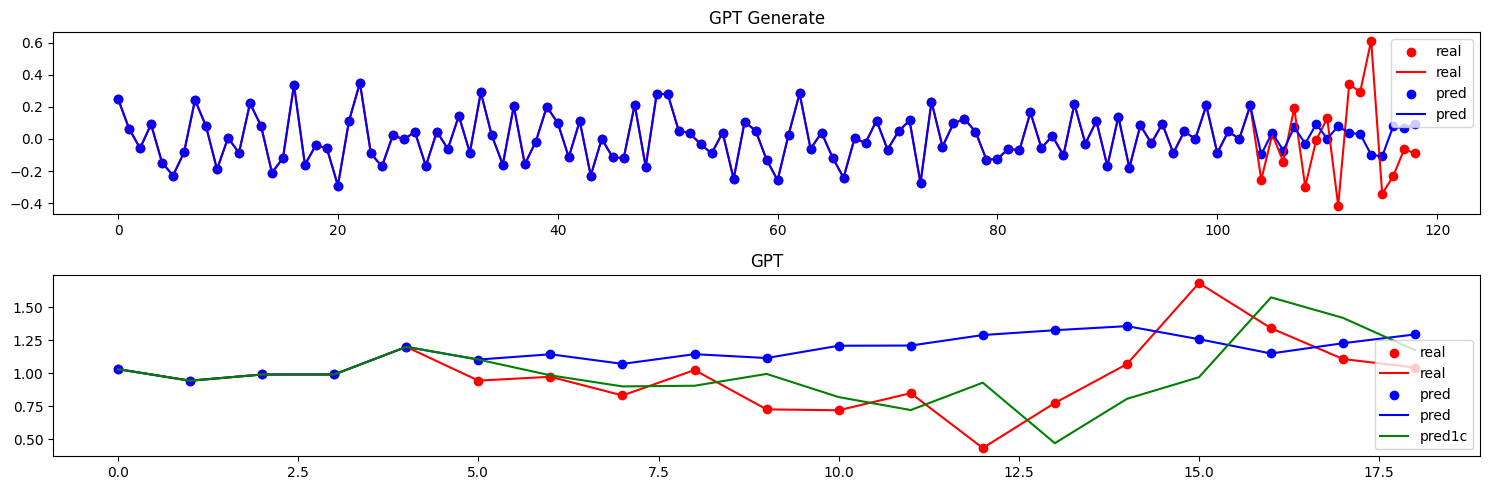

In [96]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.2310140132904053
500 train loss =  0.015502212569117546
1000 train loss =  0.007817425765097141
1500 train loss =  0.005359554197639227
2000 train loss =  0.003858843119814992
2500 train loss =  0.0029661464504897594
3000 train loss =  0.0019115816103294492
3500 train loss =  0.0018768950831145048


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


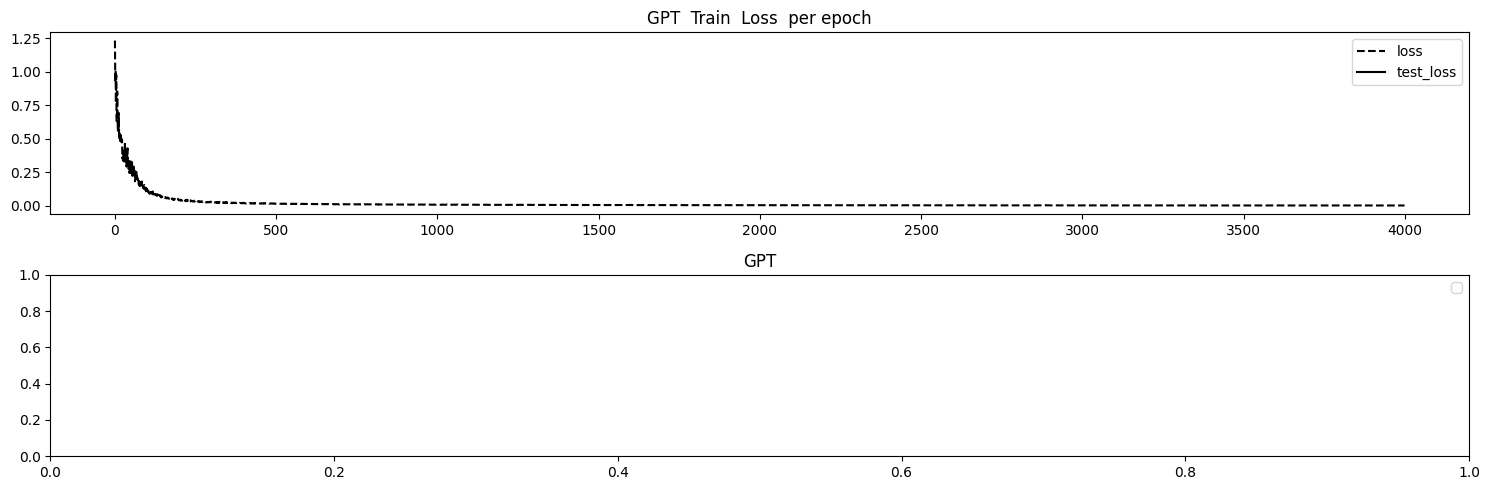

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.07018336653709412
Test MSE Loss - SI only 0-5:  0.02413731813430786
Test MSE Loss - SI only 5-10:  0.03826387599110603
Test MSE Loss - SI only 10-15:  0.09220771491527557
mae, mse, rmse, mape, mspe, rse, corr
(0.22227247, 0.07018337, 0.26492143, 8.901548, 954.0695, 1.0466304)
Testing R**2 - SI only:  -0.0954350359141416
Testing R**2 - SI only:  -0.0954350359141416
Testing R**2 - All features:  0.990709787058342


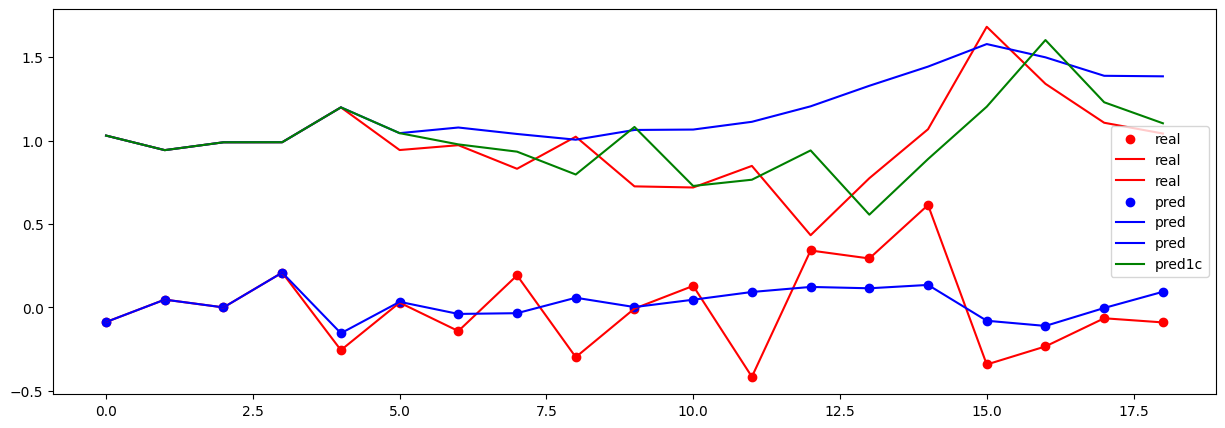

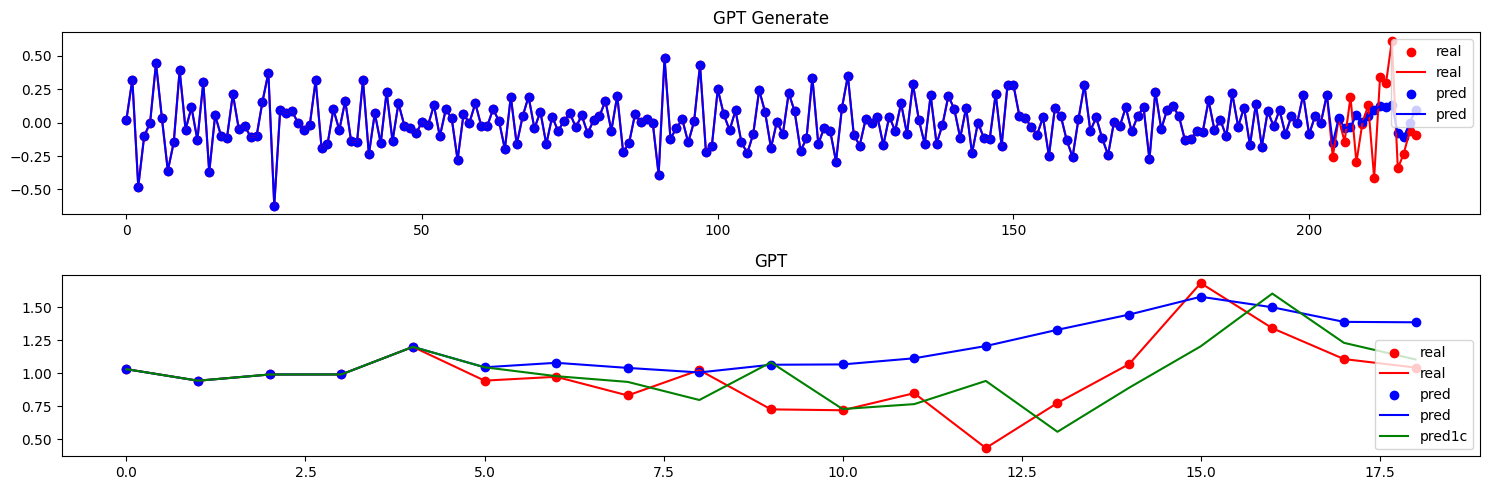

In [97]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([300, 25])
0 train loss =  1.1274534463882446
500 train loss =  0.019908703863620758
1000 train loss =  0.010162871330976486
1500 train loss =  0.0070367492735385895
2000 train loss =  0.004849505610764027
2500 train loss =  0.0033763498067855835
3000 train loss =  0.0027613788843154907
3500 train loss =  0.002663008403033018


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


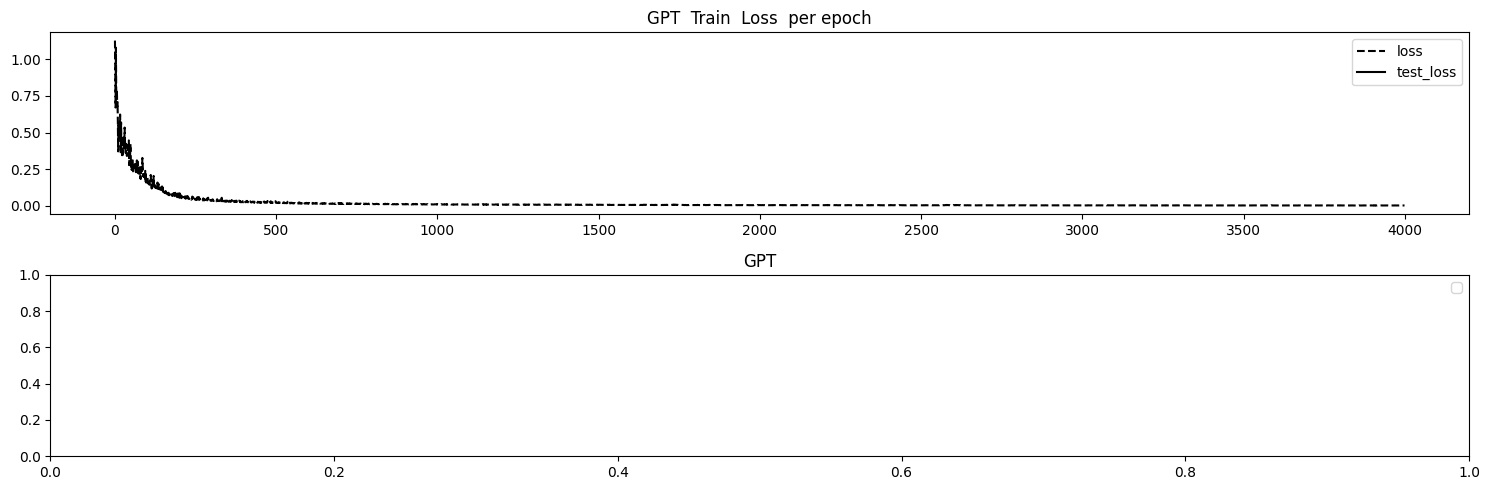

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.08879028260707855
Test MSE Loss - SI only 0-5:  0.02413731999695301
Test MSE Loss - SI only 5-10:  0.059341274201869965
Test MSE Loss - SI only 10-15:  0.11977933347225189
mae, mse, rmse, mape, mspe, rse, corr
(0.24415618, 0.088790275, 0.29797697, 9.035076, 955.9083, 1.1772236)
Testing R**2 - SI only:  -0.3858553694133937
Testing R**2 - SI only:  -0.3858553694133937
Testing R**2 - All features:  0.9893873234861457


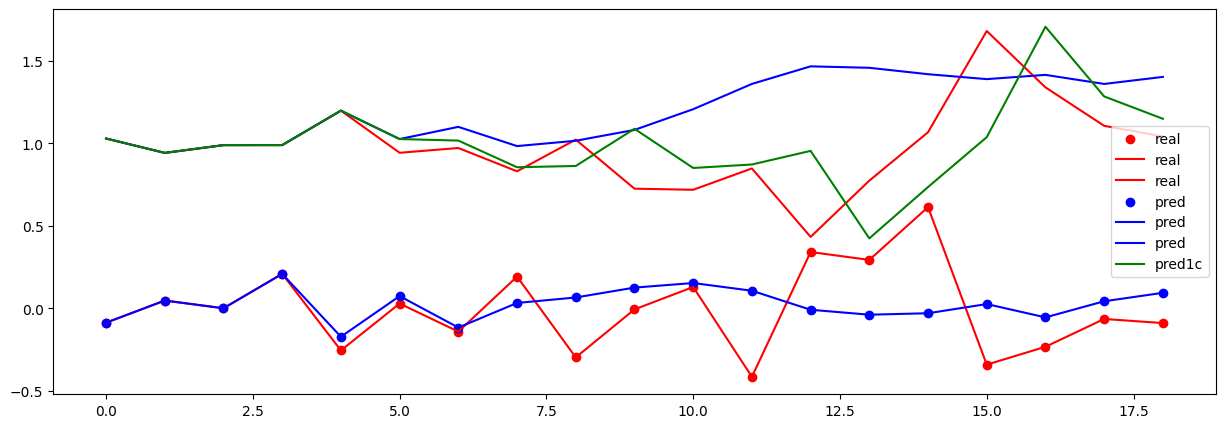

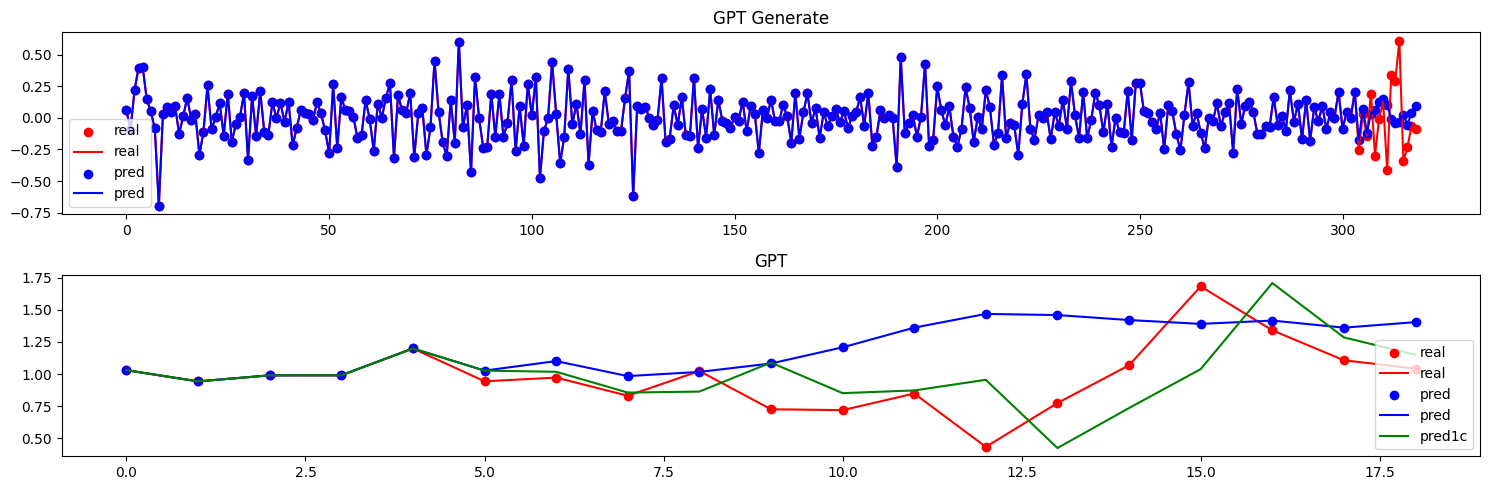

In [98]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string  = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.190187692642212
500 train loss =  0.02825653739273548
1000 train loss =  0.015276090241968632
1500 train loss =  0.009037936106324196
2000 train loss =  0.00625214446336031
2500 train loss =  0.005168285220861435
3000 train loss =  0.003654445055872202
3500 train loss =  0.0031954555306583643


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


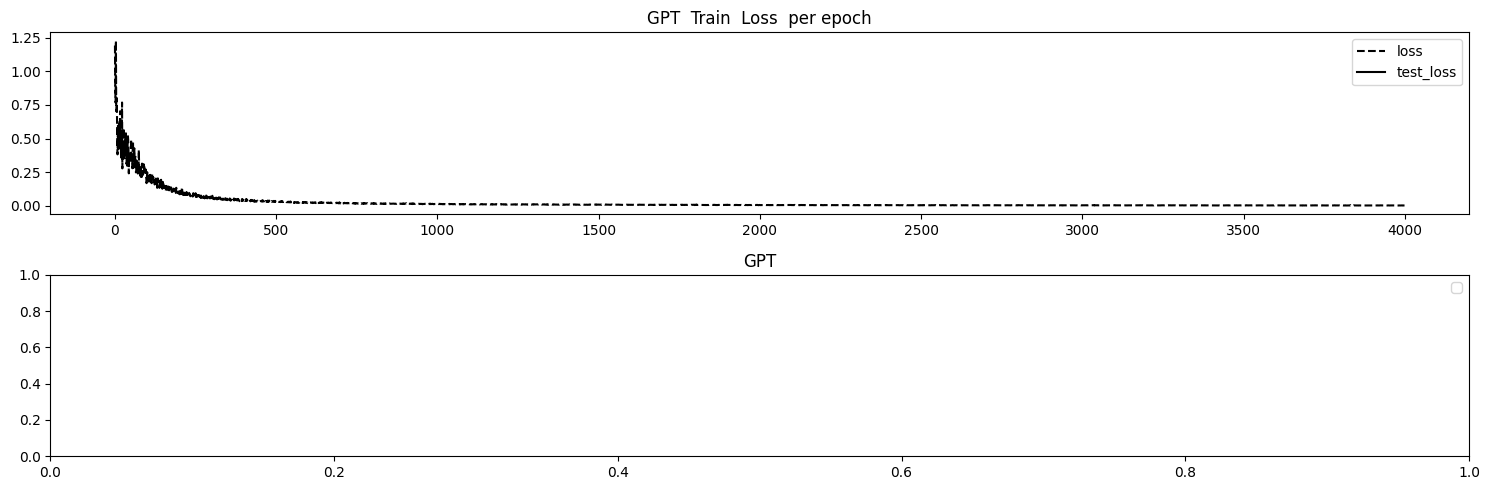

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.07471764087677002
Test MSE Loss - SI only 0-5:  0.02413732185959816
Test MSE Loss - SI only 5-10:  0.034783292561769485
Test MSE Loss - SI only 10-15:  0.1037137359380722
mae, mse, rmse, mape, mspe, rse, corr
(0.22787611, 0.07471765, 0.2733453, 8.431939, 949.01245, 1.0799106)
Testing R**2 - SI only:  -0.16620697474504031
Testing R**2 - SI only:  -0.16620697474504031
Testing R**2 - All features:  0.98350431999875


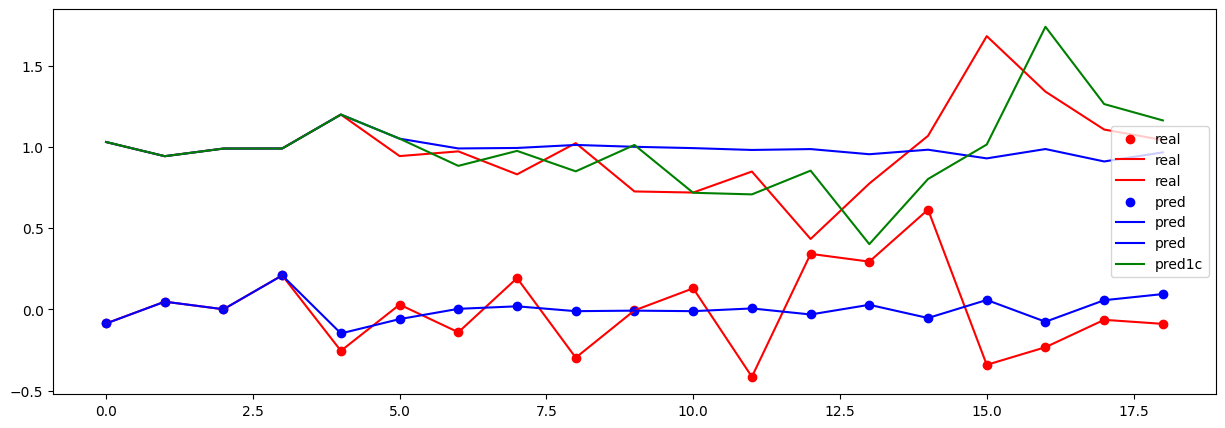

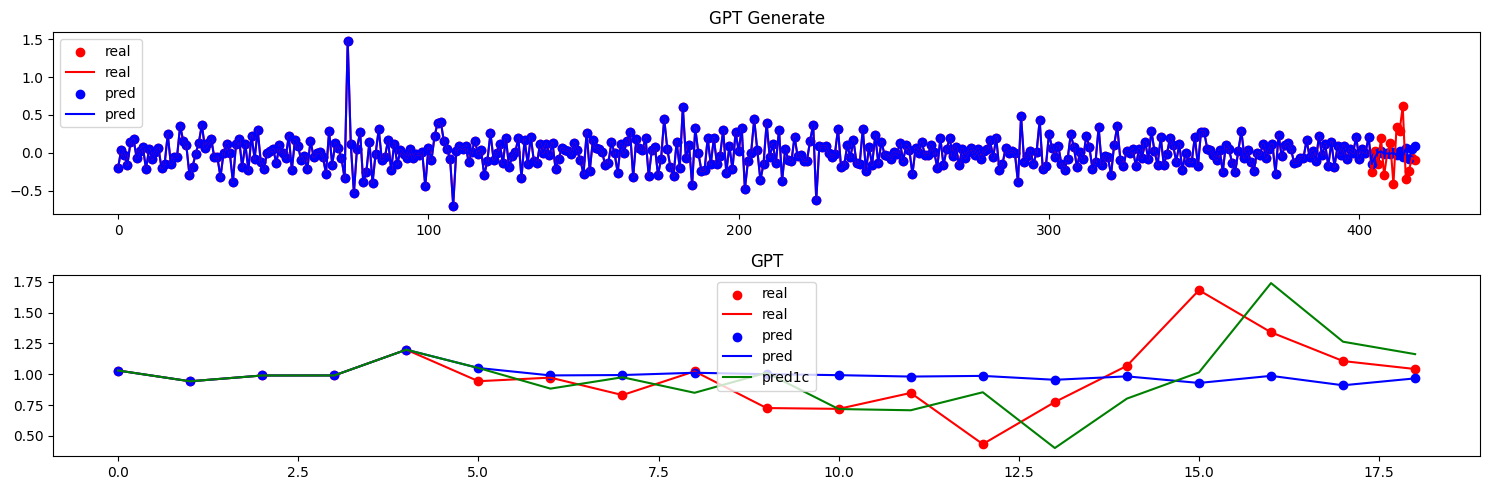

In [99]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 4


In [100]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
703
1118
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.129961609840393
500 train loss =  0.008928077295422554
1000 train loss =  0.004970066249370575
1500 train loss =  0.0035084730479866266
2000 train loss =  0.0022319587878882885
2500 train loss =  0.0015380112454295158
3000 train loss =  0.0022111183498054743
3500 train loss =  0.0010081453947350383


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


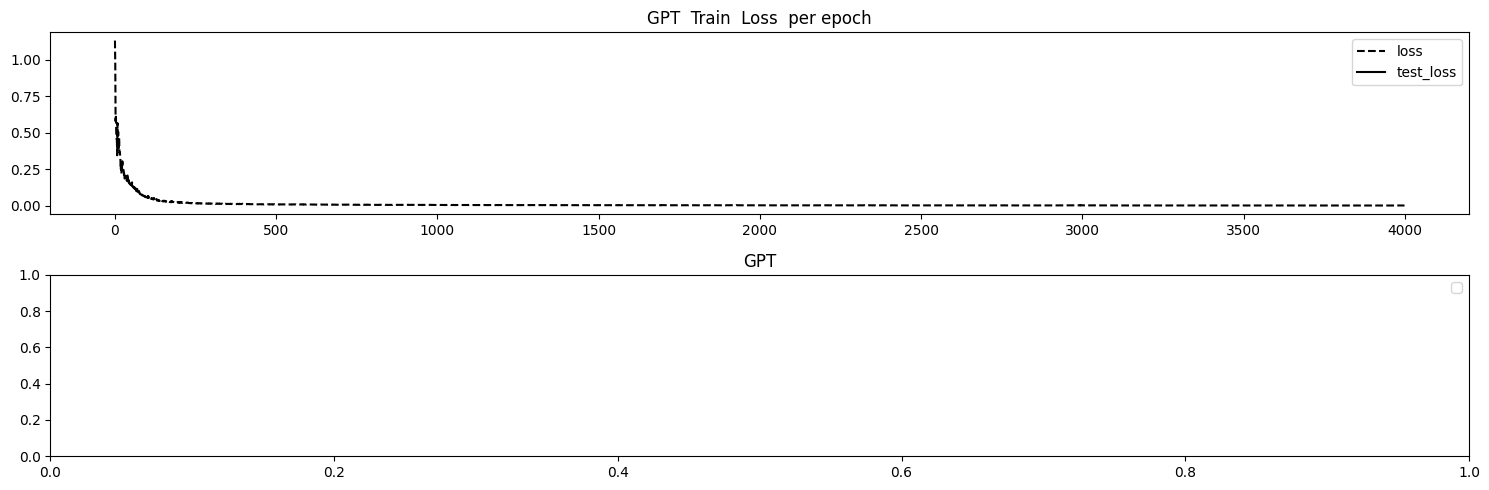

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05636905878782272
Test MSE Loss - SI only 0-5:  0.036238767206668854
Test MSE Loss - SI only 5-10:  0.031590044498443604
Test MSE Loss - SI only 10-15:  0.08387181907892227
mae, mse, rmse, mape, mspe, rse, corr
(0.19983752, 0.05636906, 0.23742169, 2.811373, 13.622899, 1.9841028)
Testing R**2 - SI only:  -2.9366636190222413
Testing R**2 - SI only:  -2.9366636190222413
Testing R**2 - All features:  0.9408768612512343


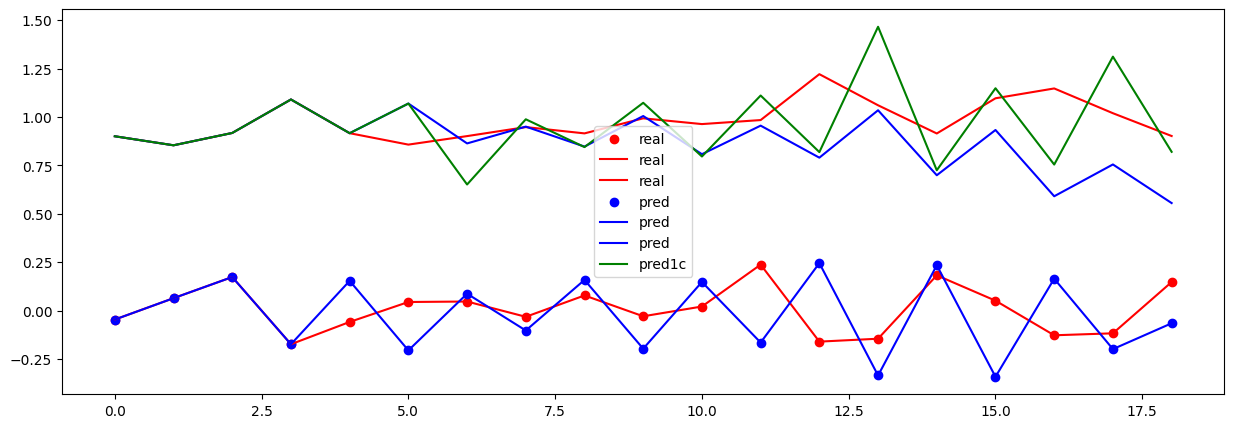

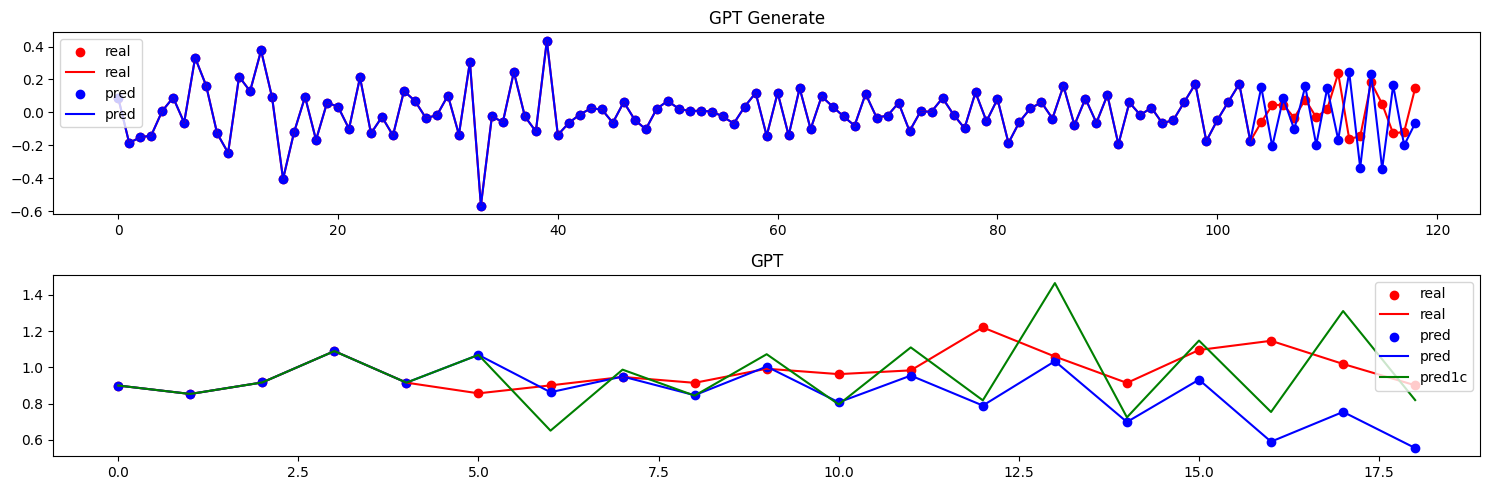

In [101]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.5833066701889038
500 train loss =  0.013864274136722088
1000 train loss =  0.007842171005904675
1500 train loss =  0.005036831367760897
2000 train loss =  0.004181997384876013
2500 train loss =  0.002779560163617134
3000 train loss =  0.0022027303930372
3500 train loss =  0.0015913508832454681


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


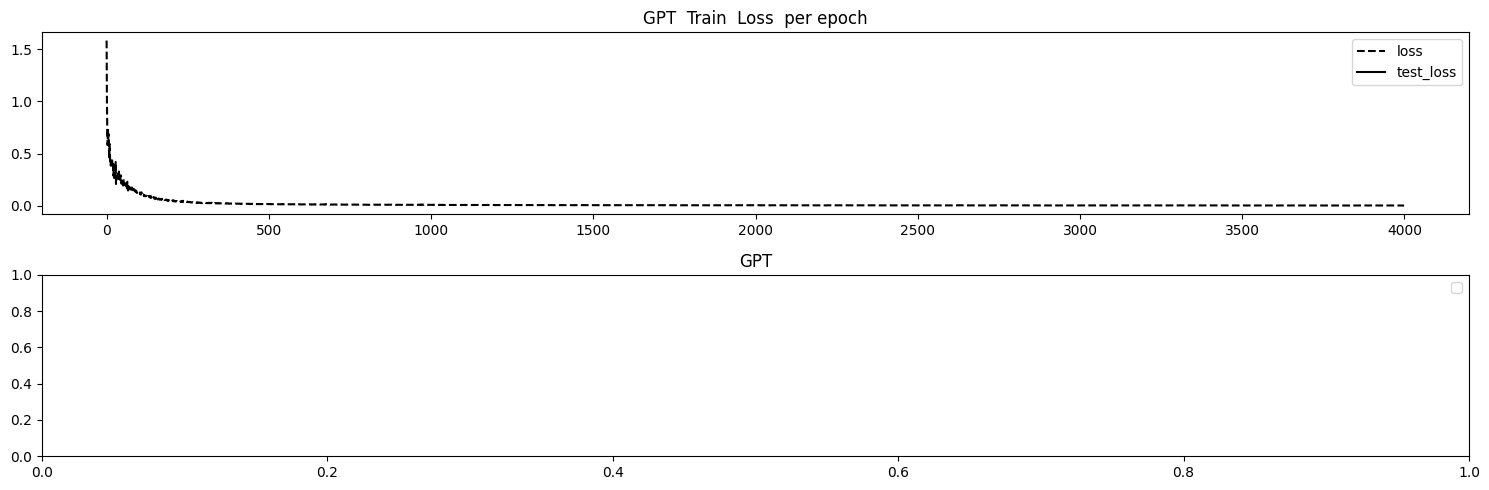

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.01980661228299141
Test MSE Loss - SI only 0-5:  0.036238767206668854
Test MSE Loss - SI only 5-10:  0.006486515048891306
Test MSE Loss - SI only 10-15:  0.020630832761526108
mae, mse, rmse, mape, mspe, rse, corr
(0.11288605, 0.01980661, 0.14073595, 1.3045102, 2.494678, 1.1761123)
Testing R**2 - SI only:  -0.38324052079222315
Testing R**2 - SI only:  -0.38324052079222315
Testing R**2 - All features:  0.9818638405964032


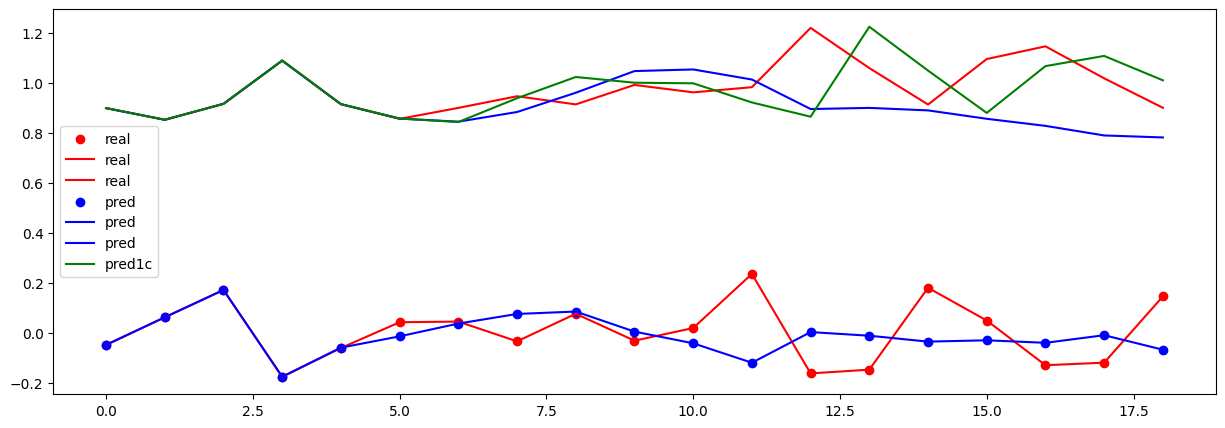

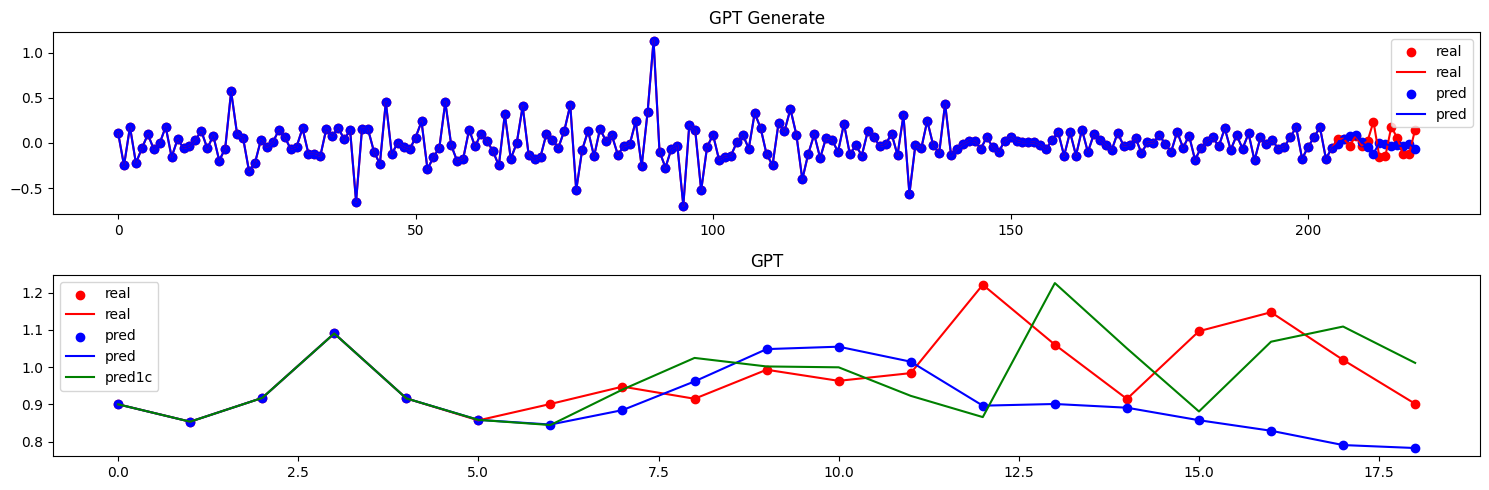

In [102]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.5130908489227295
500 train loss =  0.01927846670150757
1000 train loss =  0.010948247276246548
1500 train loss =  0.005929754115641117
2000 train loss =  0.005037542898207903
2500 train loss =  0.003337673842906952
3000 train loss =  0.00261858943849802
3500 train loss =  0.002251415280625224


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


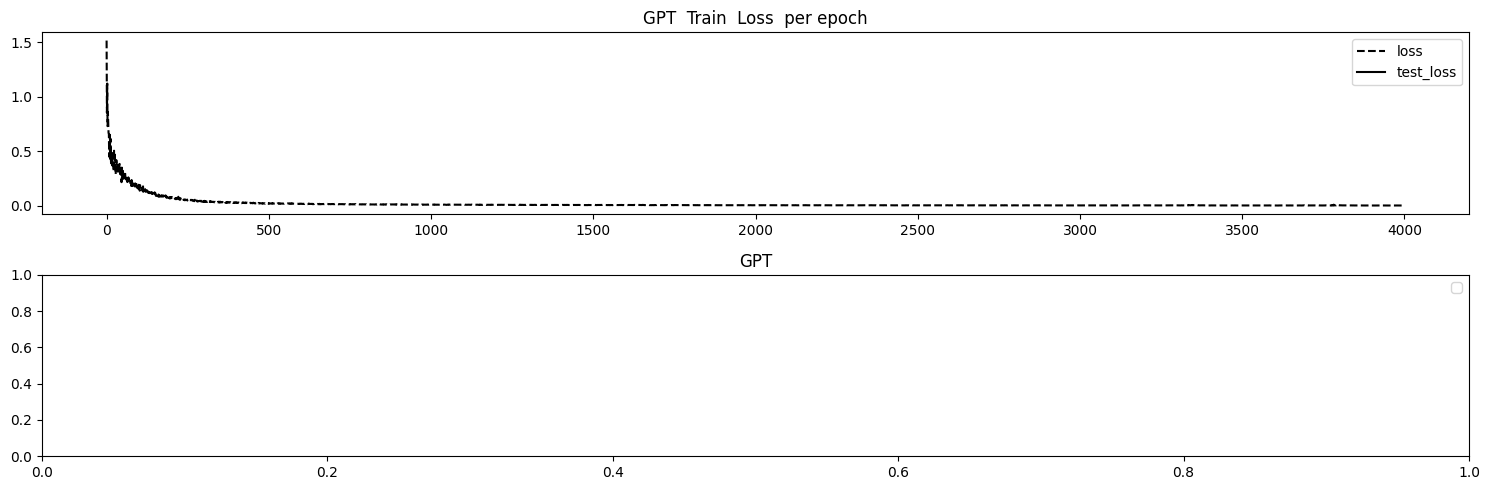

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.024759508669376373
Test MSE Loss - SI only 0-5:  0.036238767206668854
Test MSE Loss - SI only 5-10:  0.0010547947604209185
Test MSE Loss - SI only 10-15:  0.03410456329584122
mae, mse, rmse, mape, mspe, rse, corr
(0.122591846, 0.024759507, 0.15735154, 1.4485502, 4.5890326, 1.3149668)
Testing R**2 - SI only:  -0.7291373755489763
Testing R**2 - SI only:  -0.7291373755489763
Testing R**2 - All features:  0.9391762844471231


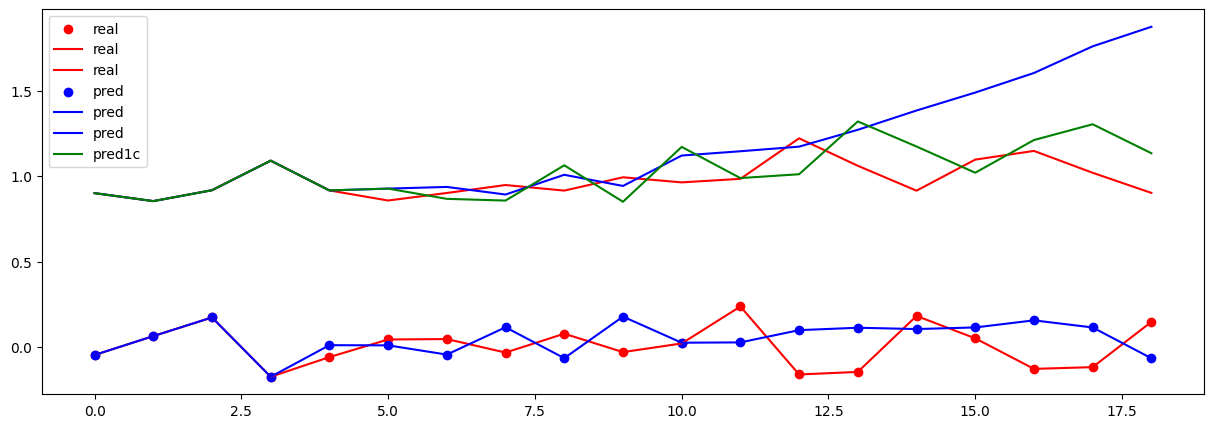

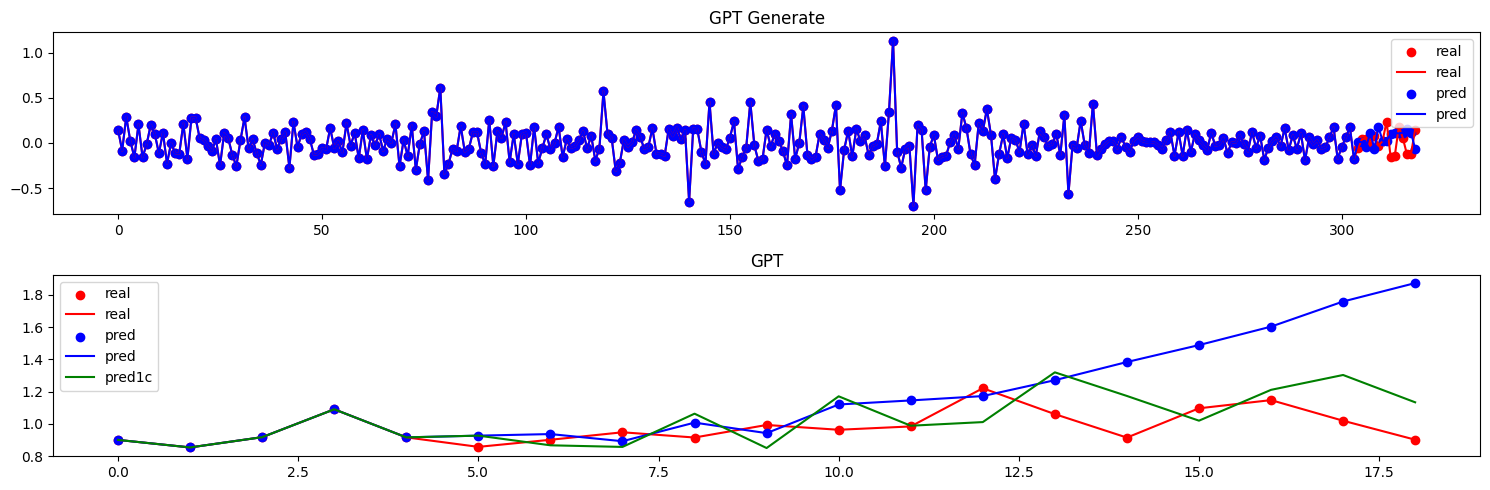

In [103]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([400, 25])
0 train loss =  1.2962616682052612
500 train loss =  0.02858508564531803
1000 train loss =  0.013242347165942192
1500 train loss =  0.00767284631729126
2000 train loss =  0.006359871942549944
2500 train loss =  0.0037089039105921984
3000 train loss =  0.003973106388002634
3500 train loss =  0.0030179827008396387


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


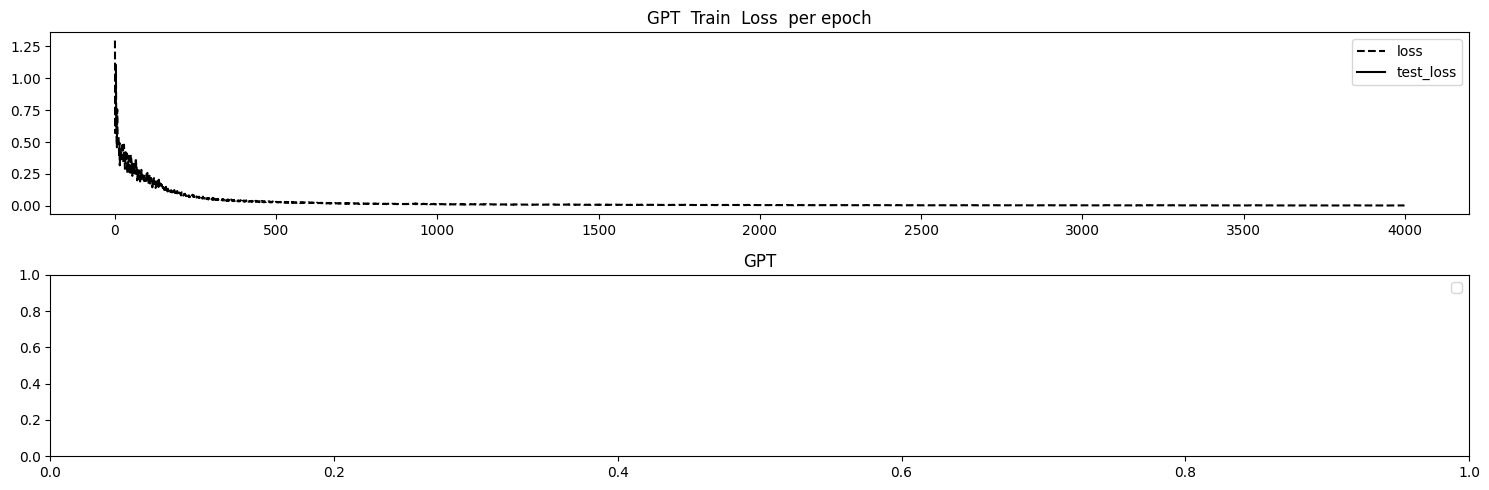

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.034818071871995926
Test MSE Loss - SI only 0-5:  0.036238767206668854
Test MSE Loss - SI only 5-10:  0.01837225630879402
Test MSE Loss - SI only 10-15:  0.04571850225329399
mae, mse, rmse, mape, mspe, rse, corr
(0.15468177, 0.034818072, 0.186596, 2.1050732, 8.27702, 1.559359)
Testing R**2 - SI only:  -1.431600576169978
Testing R**2 - SI only:  -1.431600576169978
Testing R**2 - All features:  0.92829631442385


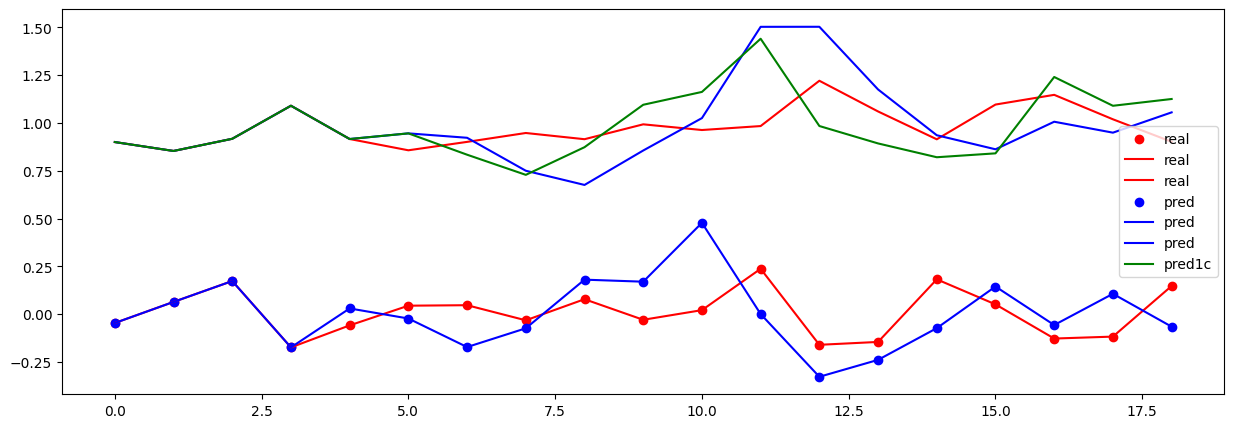

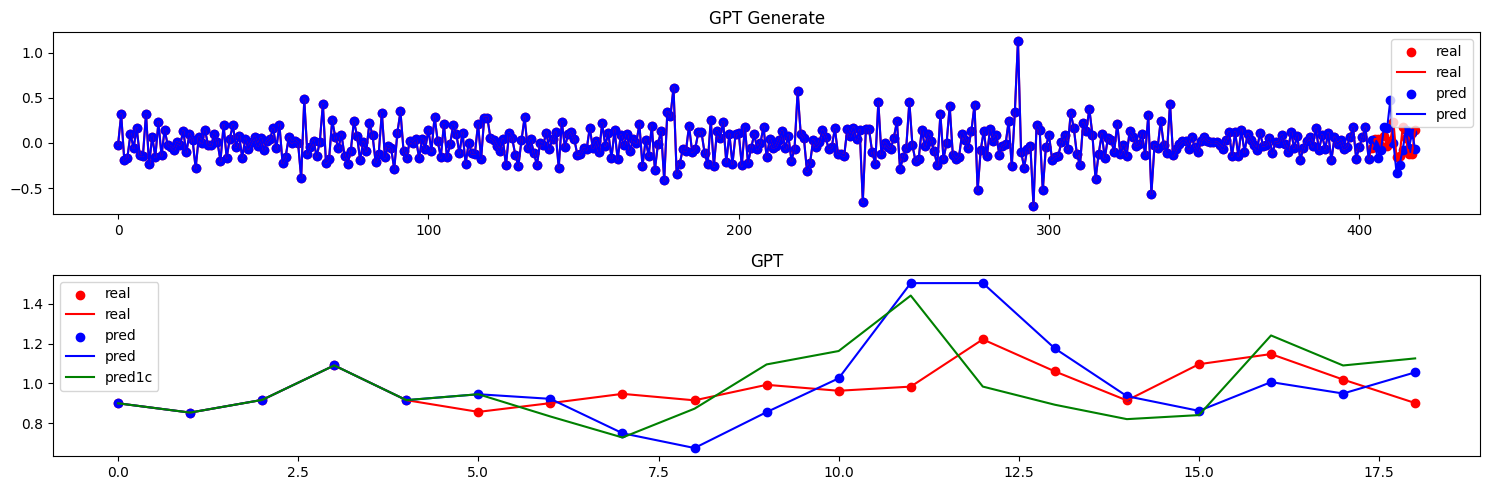

In [104]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



## Run 5


In [105]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
131
546
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.483981728553772
500 train loss =  0.008972304873168468
1000 train loss =  0.004662685561925173
1500 train loss =  0.0029384098015725613
2000 train loss =  0.0022910404950380325
2500 train loss =  0.0018934112740680575
3000 train loss =  0.0014420523075386882
3500 train loss =  0.0011956273810938


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


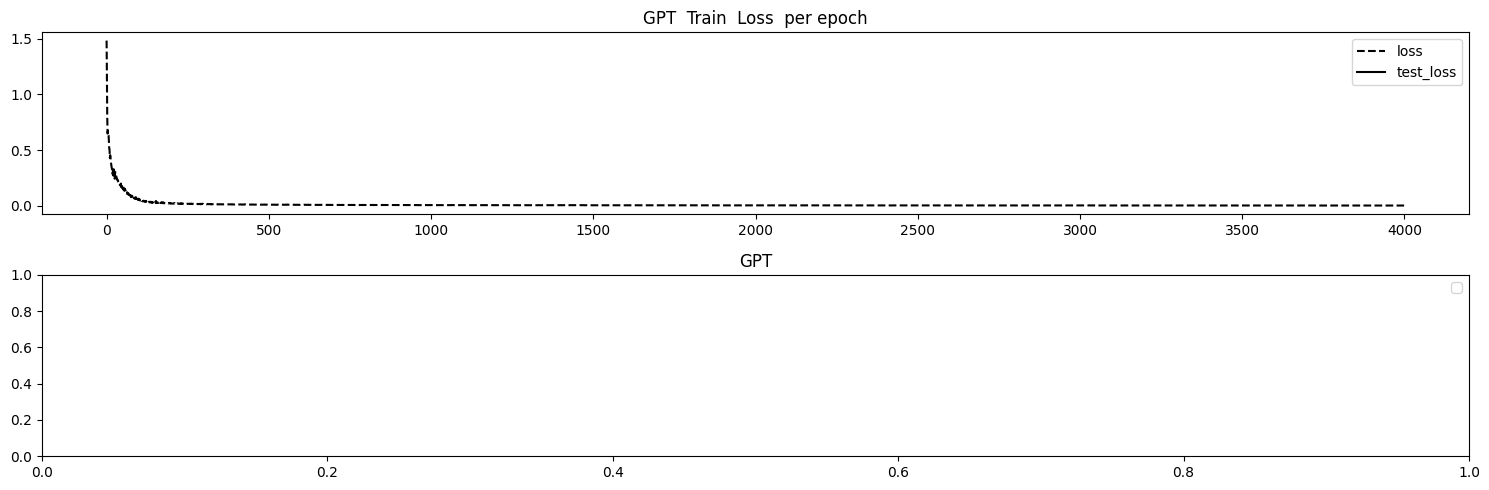

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05028776824474335
Test MSE Loss - SI only 0-5:  0.107900470495224
Test MSE Loss - SI only 5-10:  0.023738965392112732
Test MSE Loss - SI only 10-15:  0.0411146804690361
mae, mse, rmse, mape, mspe, rse, corr
(0.19297929, 0.05028777, 0.22424935, 3.6639152, 44.678177, 1.3384874)
Testing R**2 - SI only:  -0.7915487714790872
Testing R**2 - SI only:  -0.7915487714790872
Testing R**2 - All features:  0.9701685290217076


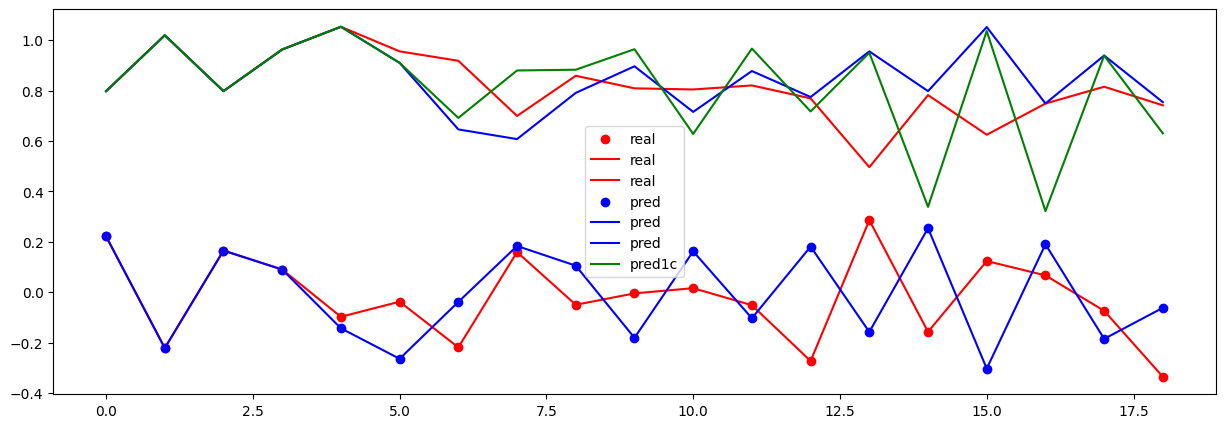

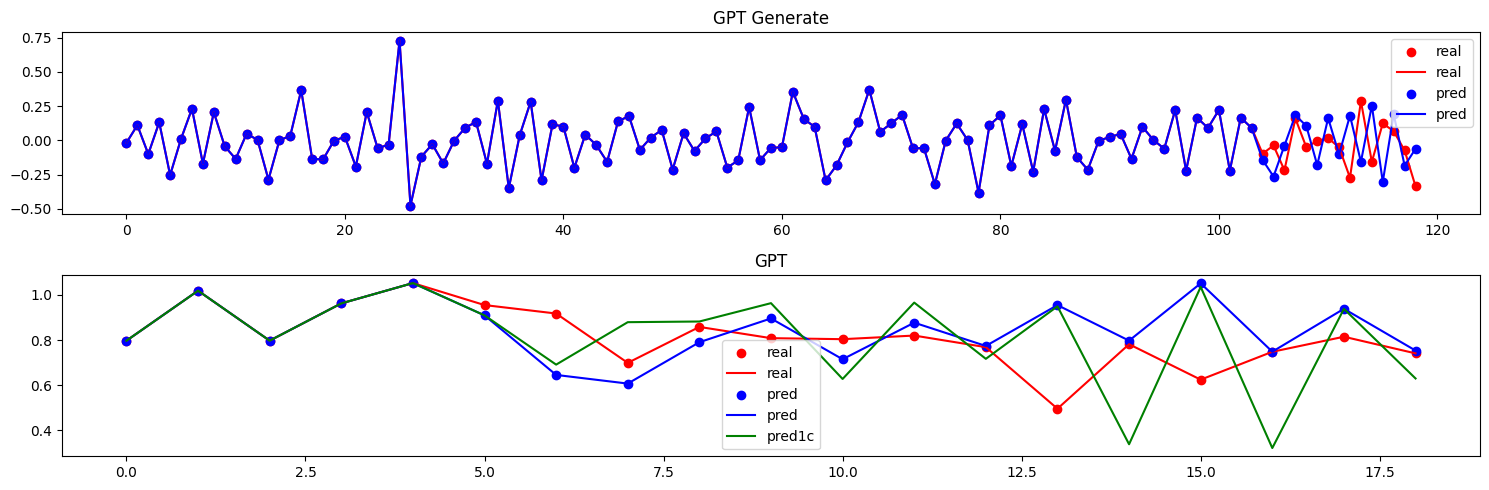

In [106]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  0.9596293568611145
500 train loss =  0.01549194473773241
1000 train loss =  0.007779685780405998
1500 train loss =  0.005259280558675528
2000 train loss =  0.004068865440785885
2500 train loss =  0.0031794686801731586
3000 train loss =  0.002244590548798442
3500 train loss =  0.0020919879898428917


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


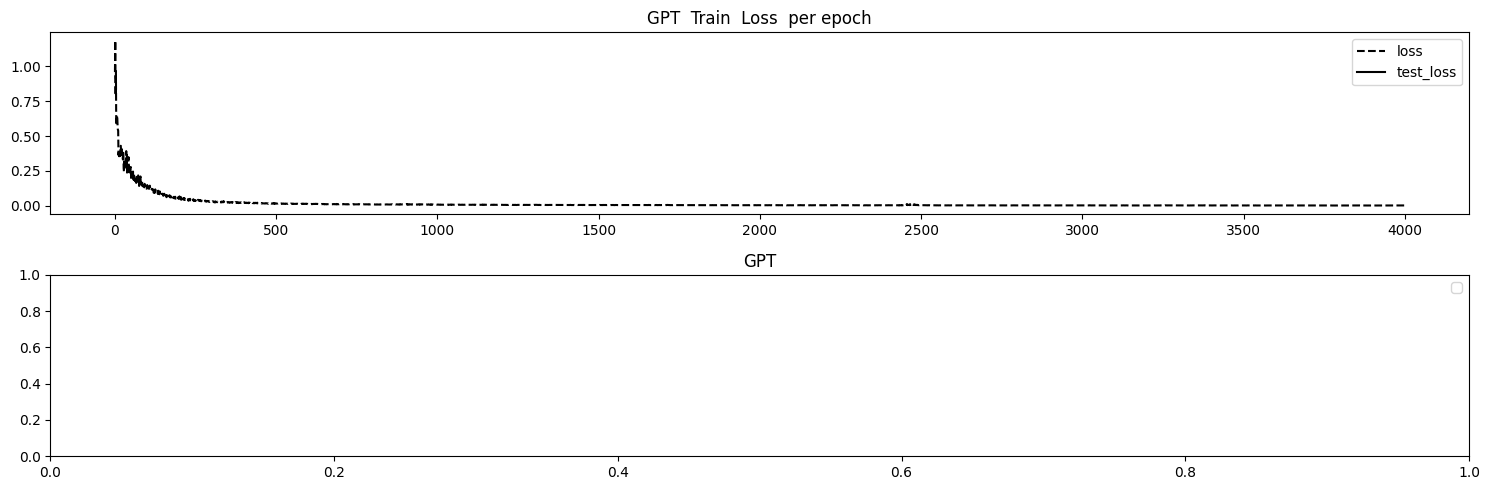

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.0482158437371254
Test MSE Loss - SI only 0-5:  0.10790048539638519
Test MSE Loss - SI only 5-10:  0.02100711688399315
Test MSE Loss - SI only 10-15:  0.038258299231529236
mae, mse, rmse, mape, mspe, rse, corr
(0.1783763, 0.048215847, 0.21958107, 1.2606928, 1.8792048, 1.3106236)
Testing R**2 - SI only:  -0.7177344514625204
Testing R**2 - SI only:  -0.7177344514625204
Testing R**2 - All features:  0.991350696870209


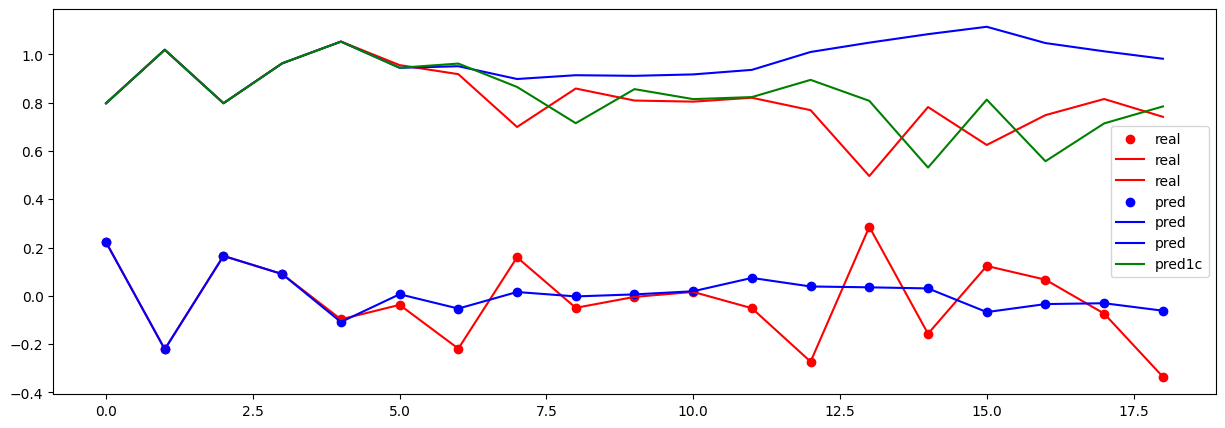

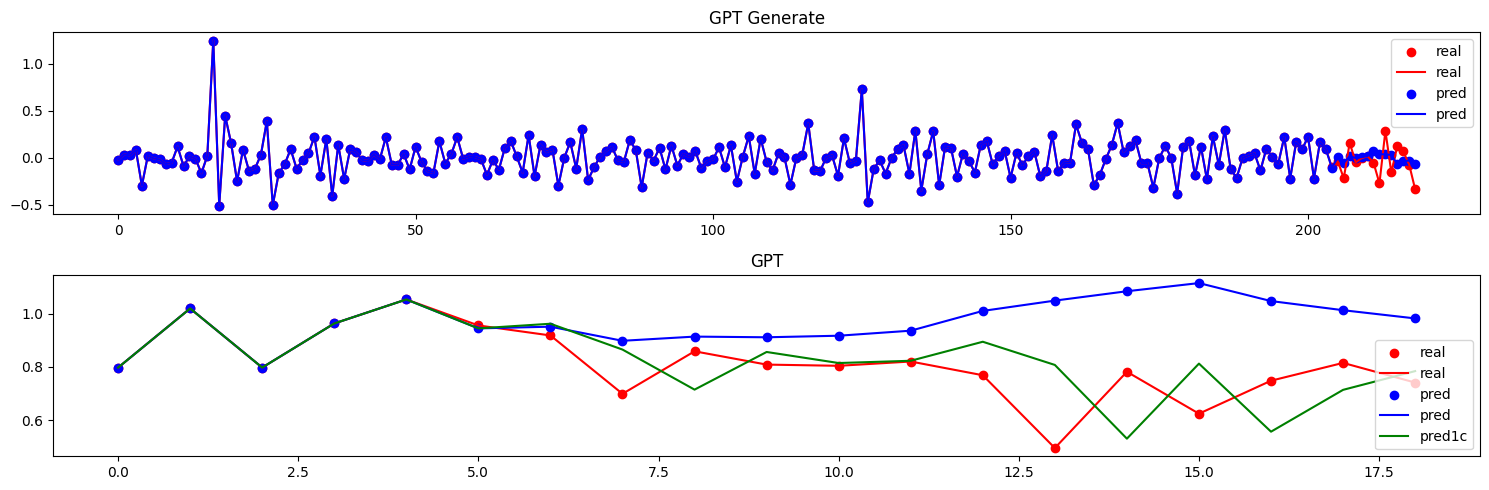

In [107]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.6721484661102295
500 train loss =  0.021791961044073105
1000 train loss =  0.012134493328630924
1500 train loss =  0.007027878891676664
2000 train loss =  0.00444828299805522
2500 train loss =  0.0035636937245726585
3000 train loss =  0.0031488602980971336
3500 train loss =  0.0022006742656230927


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


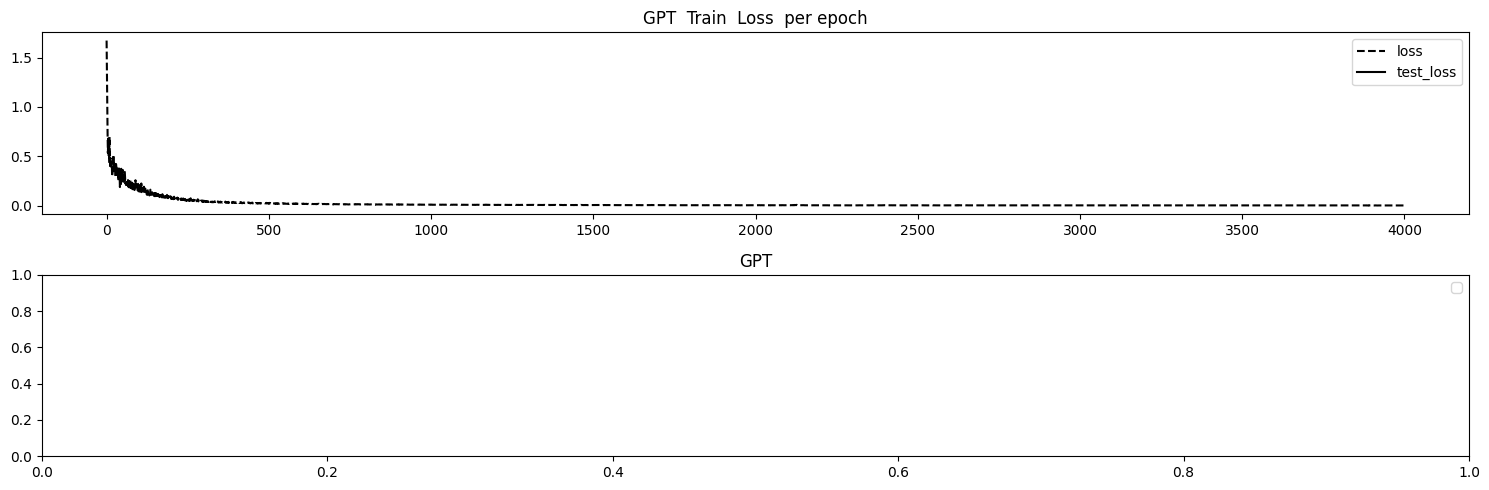

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05202197656035423
Test MSE Loss - SI only 0-5:  0.107900470495224
Test MSE Loss - SI only 5-10:  0.012761158868670464
Test MSE Loss - SI only 10-15:  0.05087456852197647
mae, mse, rmse, mape, mspe, rse, corr
(0.18510239, 0.052021977, 0.22808327, 2.2289803, 18.951366, 1.3613712)
Testing R**2 - SI only:  -0.8533315756791369
Testing R**2 - SI only:  -0.8533315756791369
Testing R**2 - All features:  0.9936860520000621


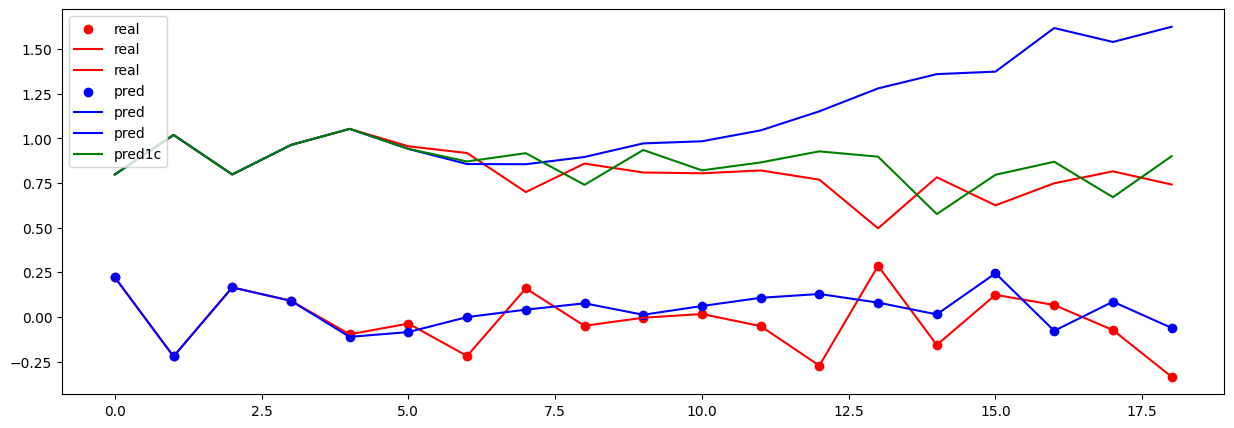

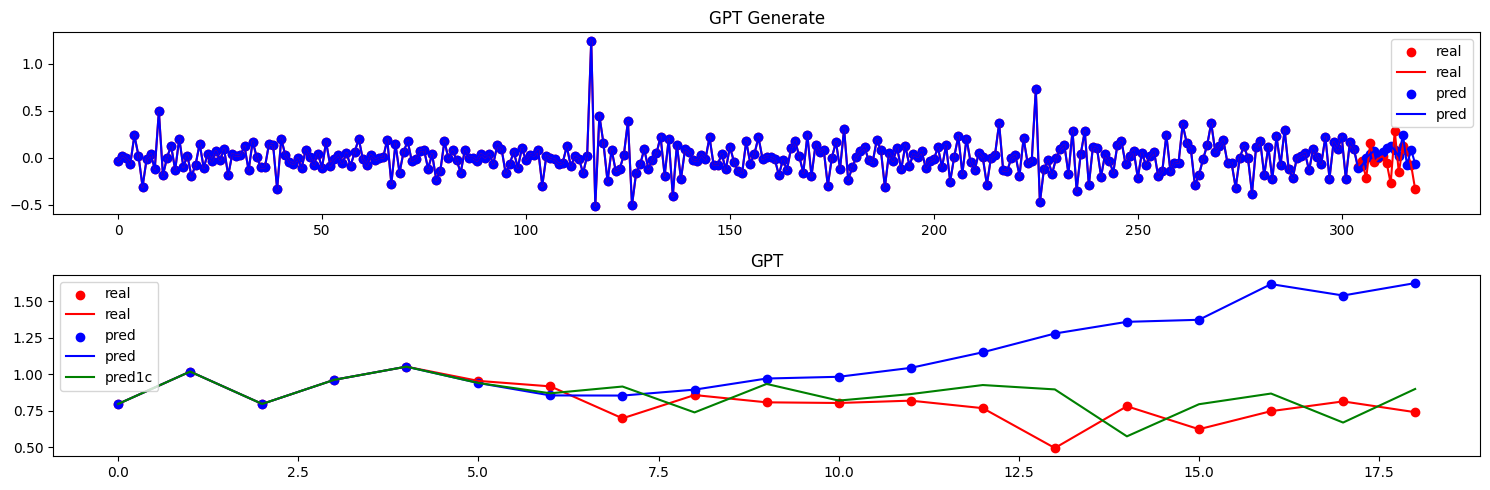

In [108]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.4916490316390991
500 train loss =  0.029851719737052917
1000 train loss =  0.012279767543077469
1500 train loss =  0.00809513870626688
2000 train loss =  0.006226578261703253
2500 train loss =  0.004216196481138468
3000 train loss =  0.0030057767871767282
3500 train loss =  0.002902550622820854


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


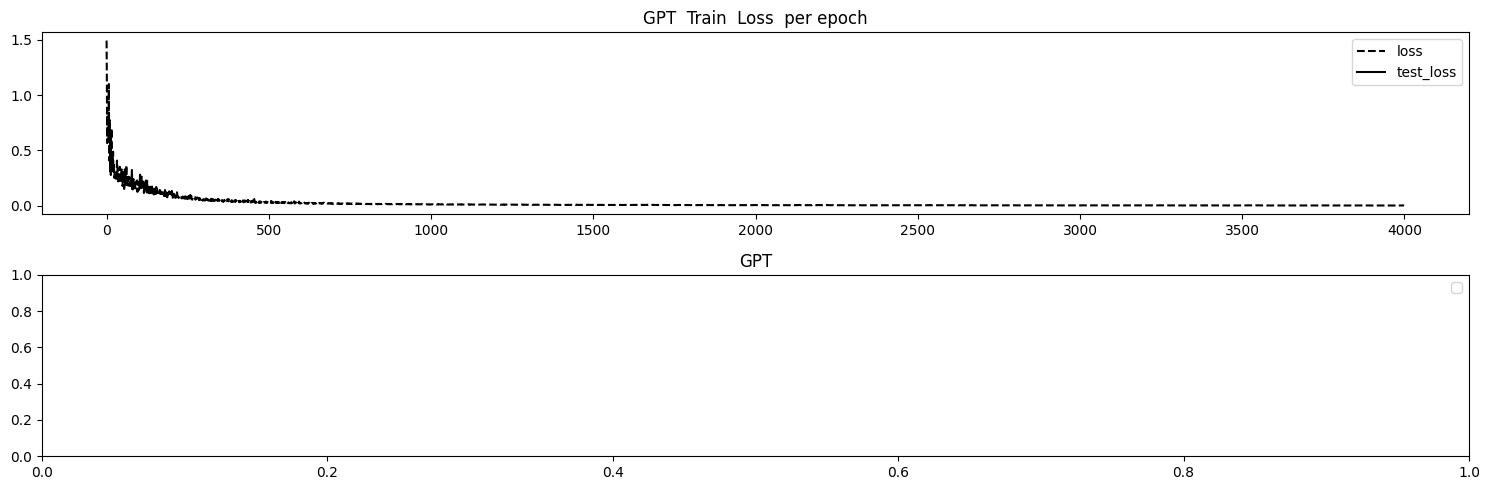

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05569862201809883
Test MSE Loss - SI only 0-5:  0.10790048539638519
Test MSE Loss - SI only 5-10:  0.01535661332309246
Test MSE Loss - SI only 10-15:  0.05719445273280144
mae, mse, rmse, mape, mspe, rse, corr
(0.19624239, 0.055698615, 0.23600554, 1.6848732, 4.0098414, 1.4086572)
Testing R**2 - SI only:  -0.9843153563544185
Testing R**2 - SI only:  -0.9843153563544185
Testing R**2 - All features:  0.990010290752471


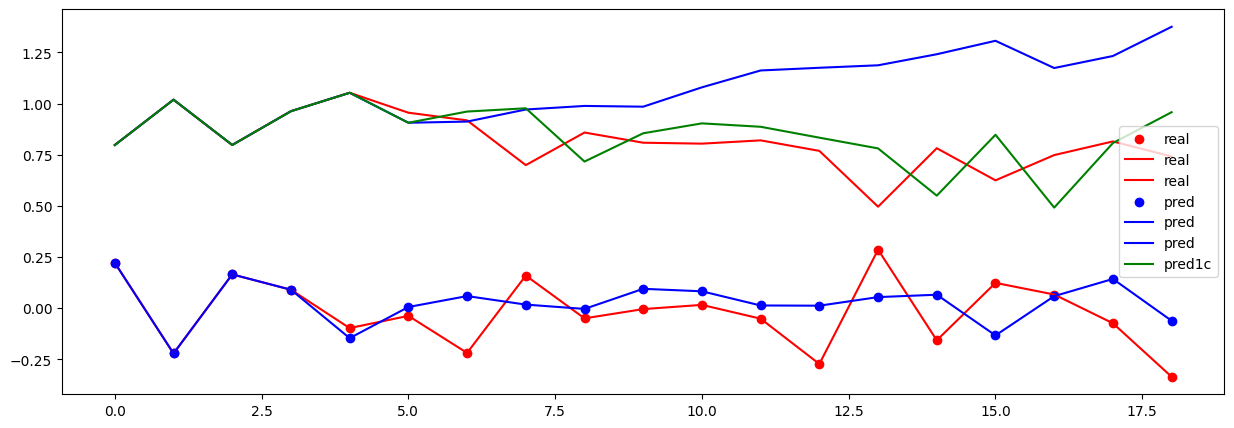

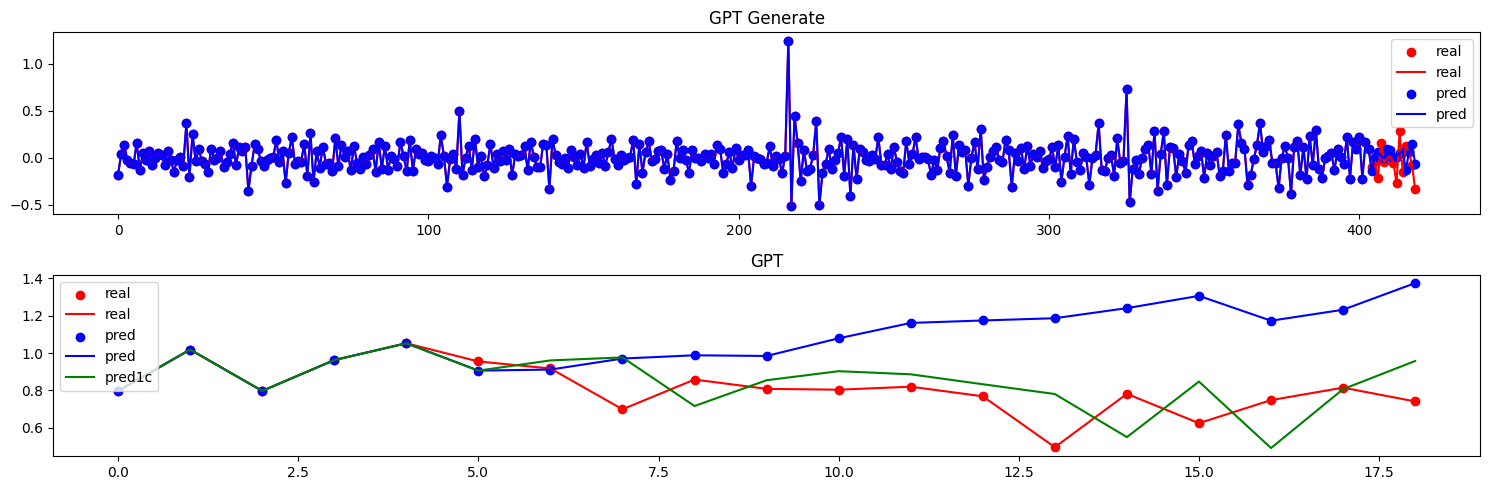

In [109]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 6


In [110]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
489
904
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.9693856239318848
500 train loss =  0.00869038887321949
1000 train loss =  0.004342738538980484
1500 train loss =  0.0029234669636934996
2000 train loss =  0.0020796533208340406
2500 train loss =  0.0020534018985927105
3000 train loss =  0.0011340267956256866
3500 train loss =  0.0009394005173817277


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


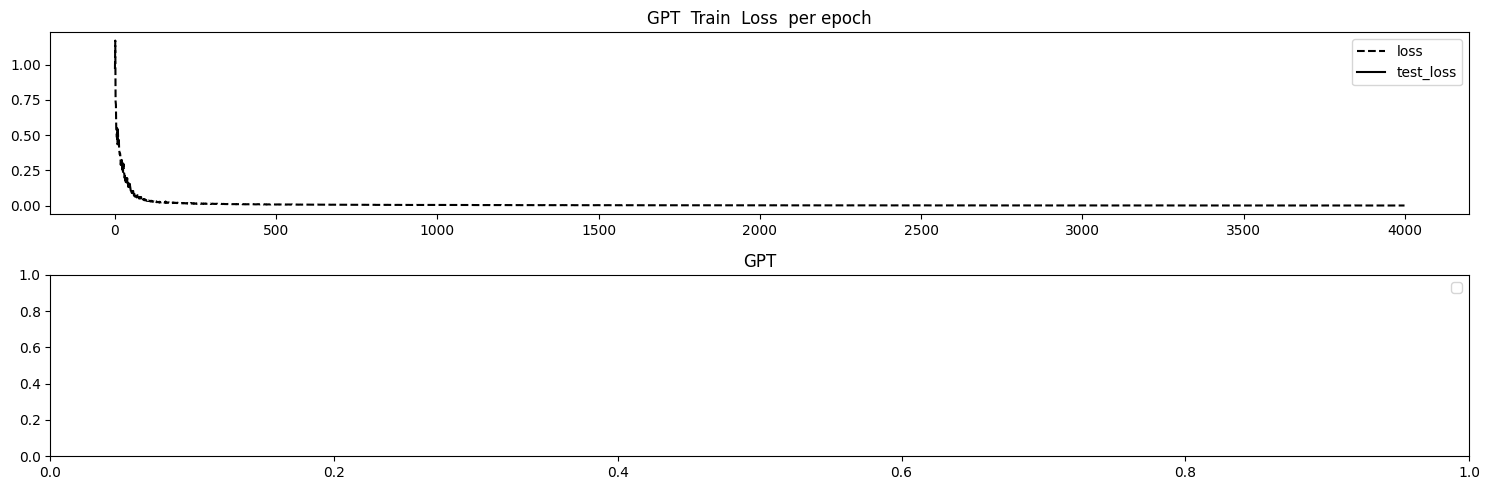

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03483129292726517
Test MSE Loss - SI only 0-5:  0.0467899851500988
Test MSE Loss - SI only 5-10:  0.02361088991165161
Test MSE Loss - SI only 10-15:  0.03949592262506485
mae, mse, rmse, mape, mspe, rse, corr
(0.15803908, 0.03483129, 0.18663143, 1.1020875, 1.678934, 1.1616907)
Testing R**2 - SI only:  -0.34952559440874786
Testing R**2 - SI only:  -0.34952559440874786
Testing R**2 - All features:  0.9847275155058142


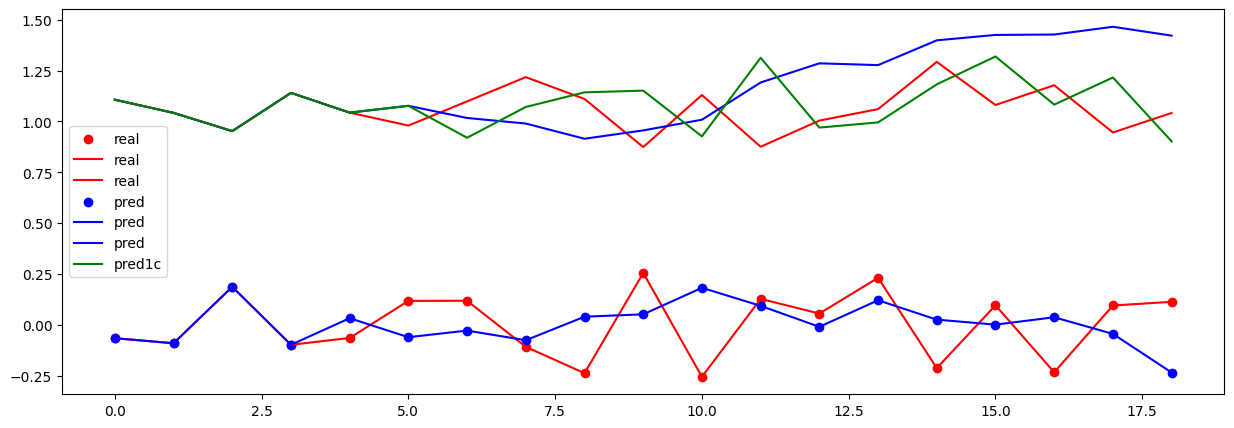

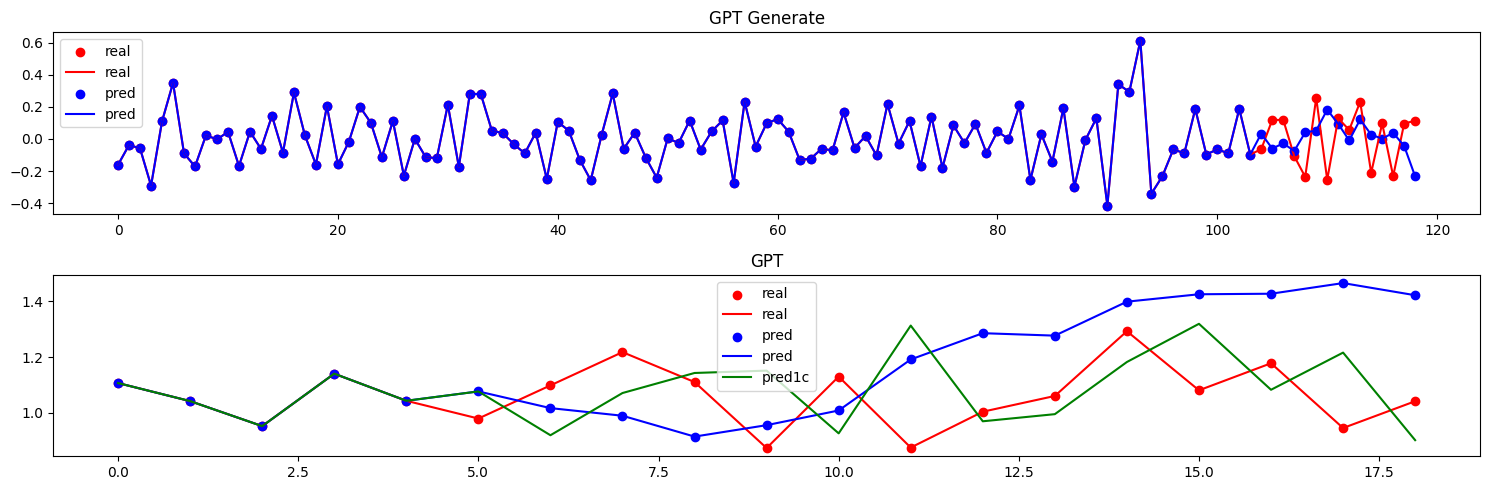

In [111]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.5161266326904297
500 train loss =  0.014294697903096676
1000 train loss =  0.007082593161612749
1500 train loss =  0.005117008928209543
2000 train loss =  0.0038859194610267878
2500 train loss =  0.002698585856705904
3000 train loss =  0.002449802588671446
3500 train loss =  0.001798187498934567


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


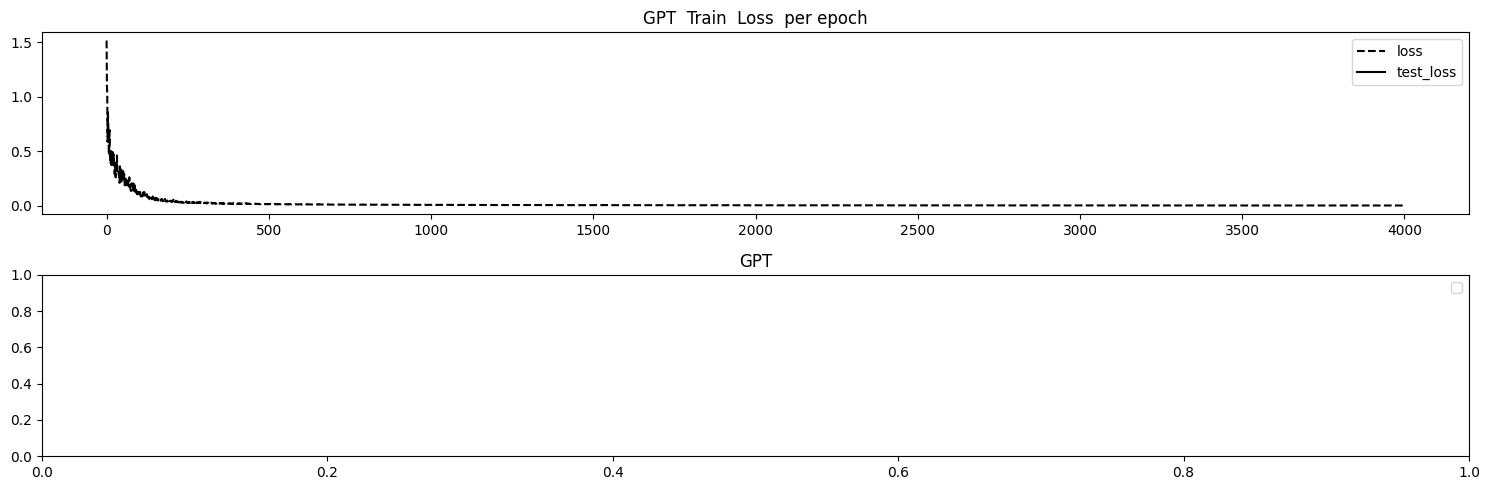

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03522944822907448
Test MSE Loss - SI only 0-5:  0.0467899814248085
Test MSE Loss - SI only 5-10:  0.027239281684160233
Test MSE Loss - SI only 10-15:  0.03832069784402847
mae, mse, rmse, mape, mspe, rse, corr
(0.16738592, 0.03522945, 0.1876951, 1.2782062, 2.2625866, 1.1683116)
Testing R**2 - SI only:  -0.36495195197200037
Testing R**2 - SI only:  -0.36495195197200037
Testing R**2 - All features:  0.9924173224233211


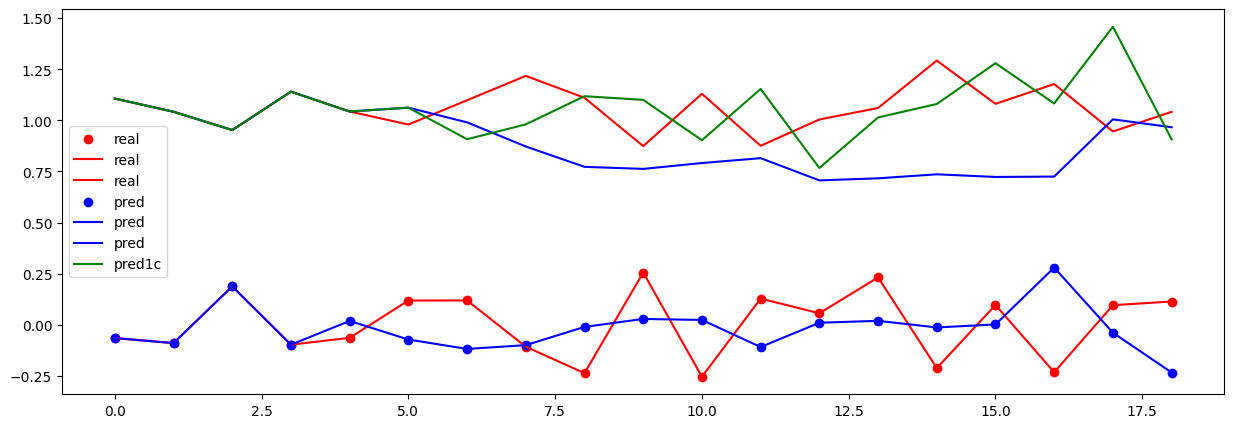

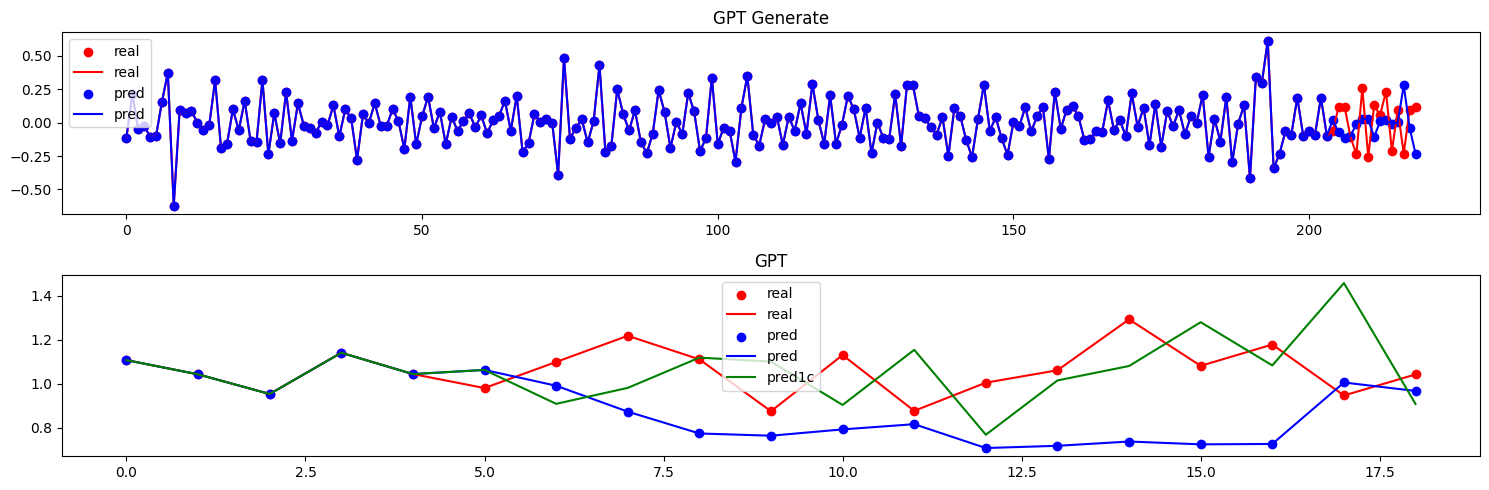

In [112]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.3215380907058716
500 train loss =  0.018901312723755836
1000 train loss =  0.009857534430921078
1500 train loss =  0.006677233148366213
2000 train loss =  0.0047257160767912865
2500 train loss =  0.003216041950508952
3000 train loss =  0.0034250221215188503
3500 train loss =  0.0027690506540238857


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


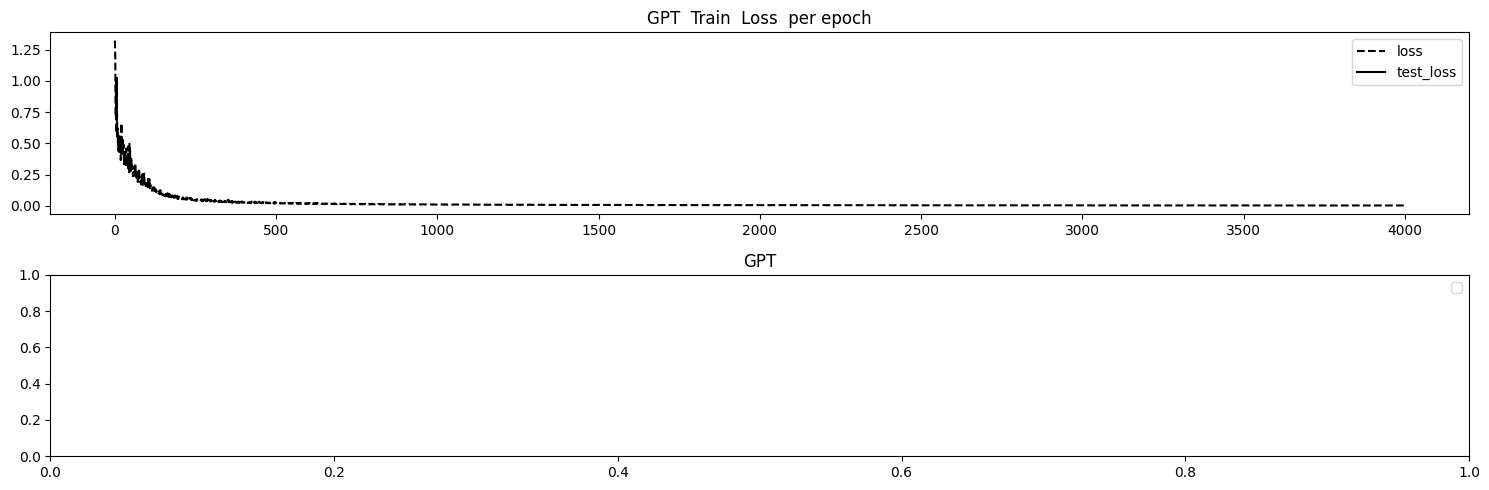

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.0351506806910038
Test MSE Loss - SI only 0-5:  0.0467899888753891
Test MSE Loss - SI only 5-10:  0.037844814360141754
Test MSE Loss - SI only 10-15:  0.03226245194673538
mae, mse, rmse, mape, mspe, rse, corr
(0.16467321, 0.035150677, 0.18748514, 1.1860008, 1.8583924, 1.1670048)
Testing R**2 - SI only:  -0.3619002353599634
Testing R**2 - SI only:  -0.3619002353599634
Testing R**2 - All features:  0.9946464851412595


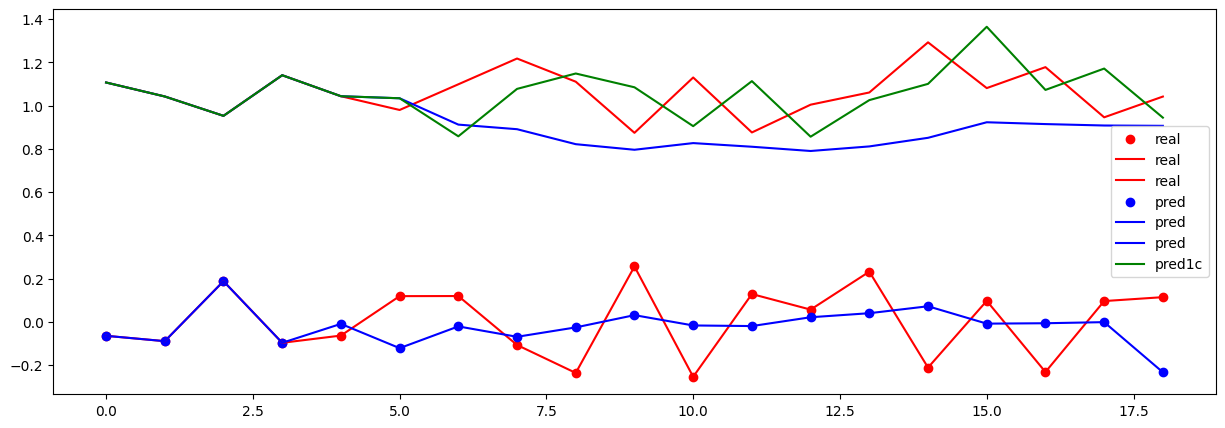

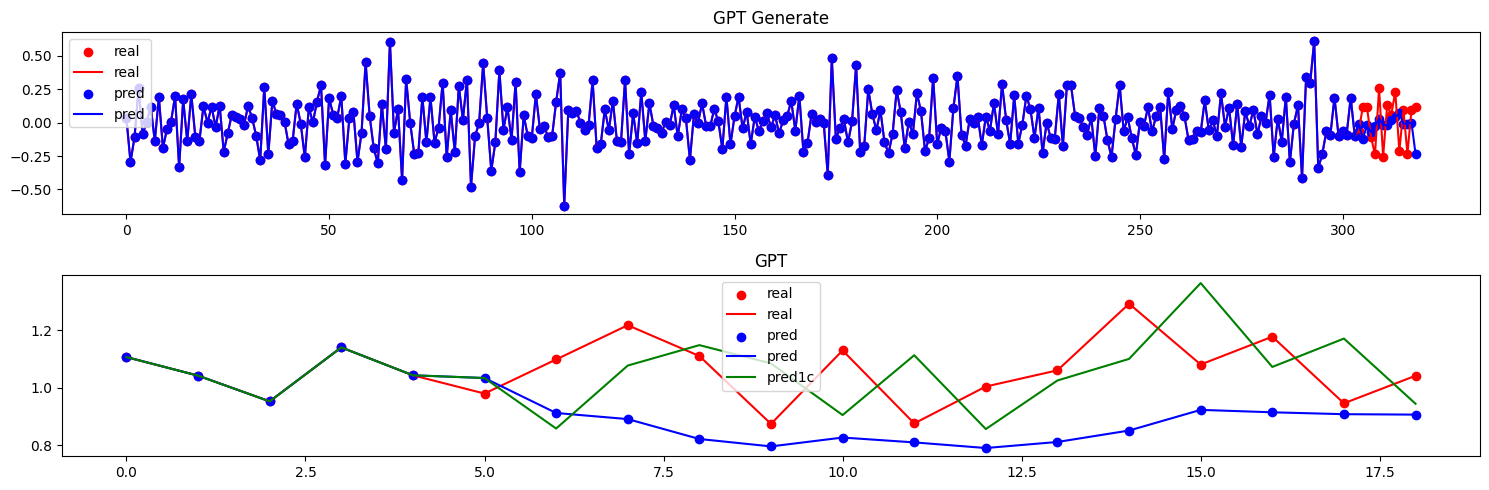

In [113]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.4411964416503906
500 train loss =  0.026734868064522743
1000 train loss =  0.011895296163856983
1500 train loss =  0.007208570372313261
2000 train loss =  0.005649252329021692
2500 train loss =  0.004479588009417057
3000 train loss =  0.003444087691605091
3500 train loss =  0.0023863548412919044


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


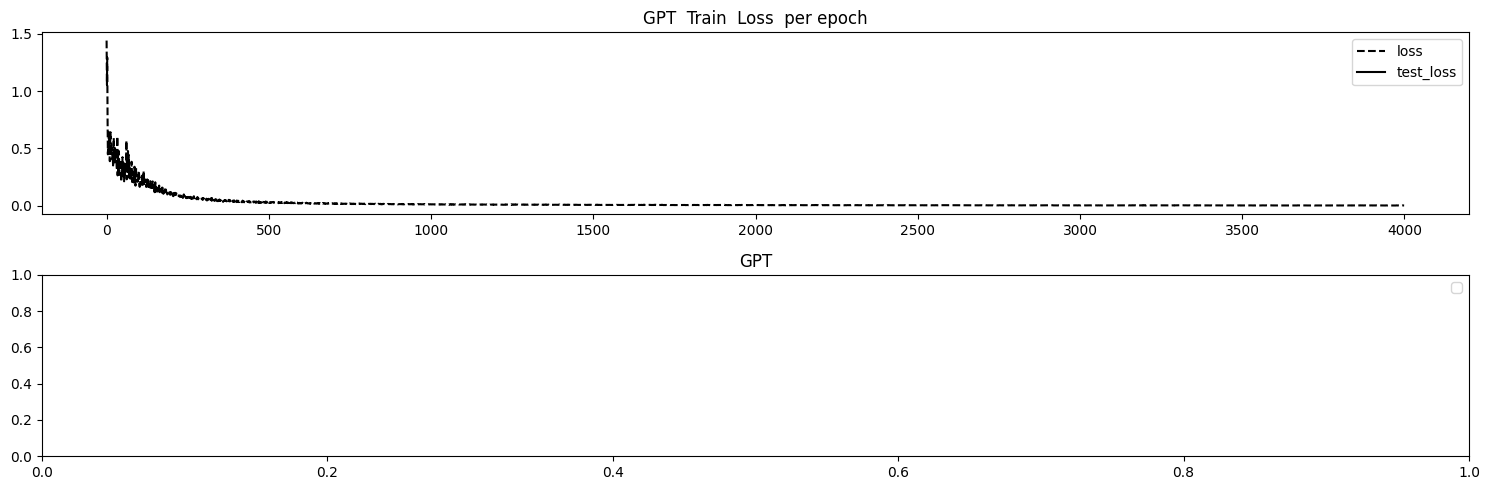

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.035605885088443756
Test MSE Loss - SI only 0-5:  0.0467899814248085
Test MSE Loss - SI only 5-10:  0.035697612911462784
Test MSE Loss - SI only 10-15:  0.0344163253903389
mae, mse, rmse, mape, mspe, rse, corr
(0.17033285, 0.03560589, 0.18869522, 1.2931247, 2.1480572, 1.174537)
Testing R**2 - SI only:  -0.3795369276852463
Testing R**2 - SI only:  -0.3795369276852463
Testing R**2 - All features:  0.9952149925159083


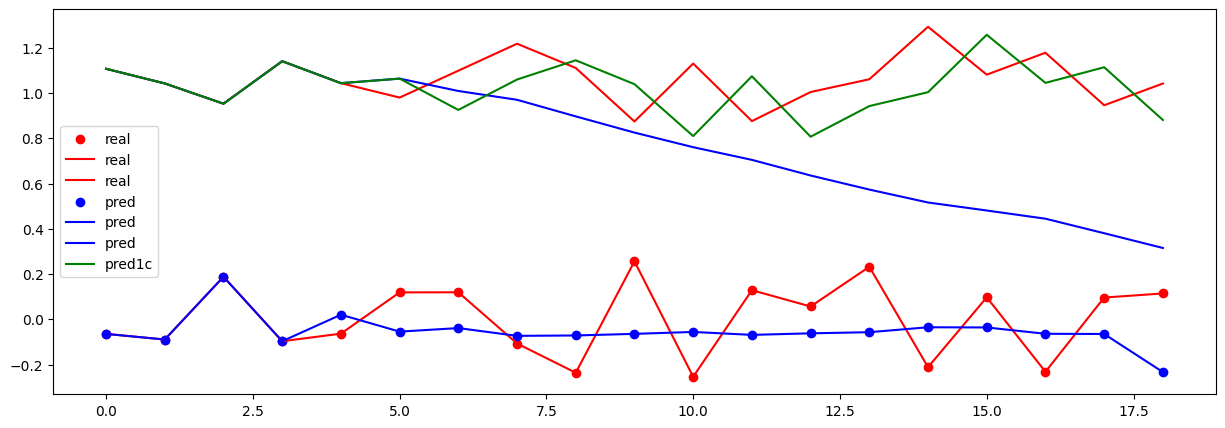

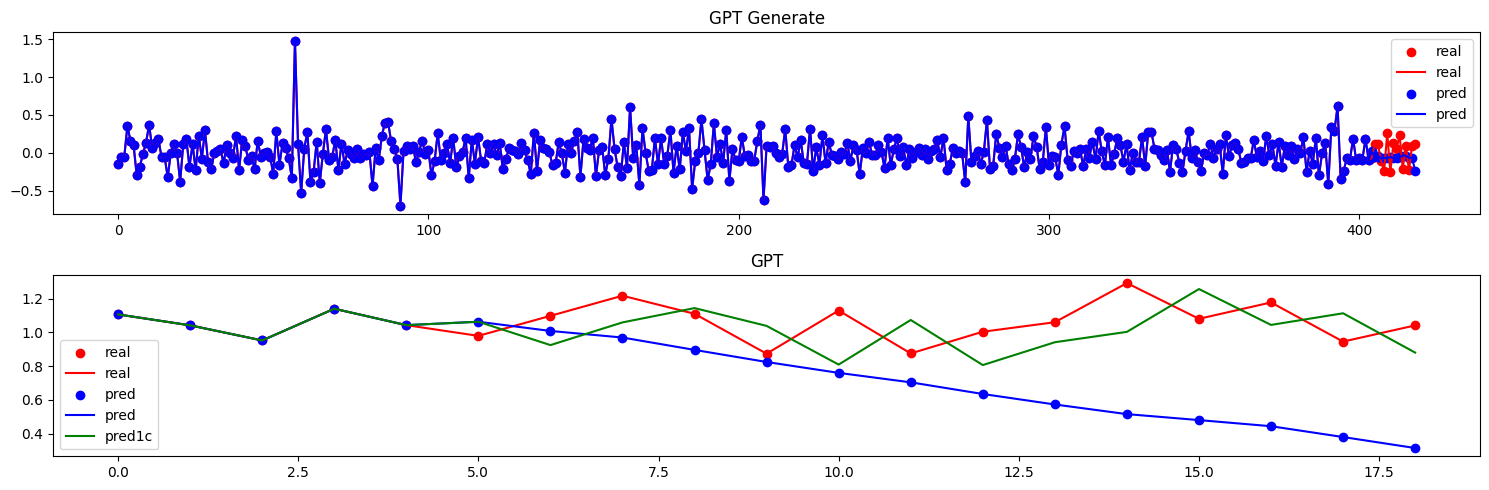

In [114]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()
